In [1]:
# import necessary libraries
import numpy as np
import pandas as pd
import tensorflow_hub as hub
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, Concatenate, Conv1D, GlobalMaxPooling1D, Flatten
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split   
from tensorflow.keras.optimizers.legacy import Adam
from tqdm import tqdm
from fast_ml.model_development import train_valid_test_split
from imblearn.metrics import geometric_mean_score

2024-07-15 12:04:43.182378: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-15 12:04:43.208425: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-15 12:04:43.630227: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [25]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, Flatten, MaxPooling1D

In [4]:
data = pd.read_csv('updated_dataframe.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5802 entries, 0 to 5801
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   retweet_count     5802 non-null   float64
 1   favorite_count    5802 non-null   float64
 2   followers_count   5802 non-null   float64
 3   friends_count     5802 non-null   float64
 4   verified          5802 non-null   float64
 5   time_delay (min)  5802 non-null   float64
 6   neg_sent          5802 non-null   float64
 7   pos_sent          5802 non-null   float64
 8   neu_sent          5802 non-null   float64
 9   comp_sent         5802 non-null   float64
 10  difference        5802 non-null   float64
 11  weight            5802 non-null   float64
 12  ratio             5802 non-null   float64
 13  elmo_0            5802 non-null   float64
 14  elmo_1            5802 non-null   float64
dtypes: float64(15)
memory usage: 680.0 KB


In [5]:
data.isna().sum()

retweet_count       0
favorite_count      0
followers_count     0
friends_count       0
verified            0
time_delay (min)    0
neg_sent            0
pos_sent            0
neu_sent            0
comp_sent           0
difference          0
weight              0
ratio               0
elmo_0              0
elmo_1              0
dtype: int64

In [46]:
numerical_data = data[['retweet_count', 'favorite_count', 'followers_count', 'friends_count', 'verified',
                           'time_delay (min)', 'neg_sent', 'pos_sent', 'neu_sent', 'comp_sent', 'difference', 'ratio']].values

In [48]:
data_label = pd.read_csv('data.csv')
labels  = data_label['label'].values
text_data = data_label['tweet_text'].values
print(text[:4])

['Reports of "moving body" amidst #Germanwings wreckage #A320 http://t.co/GLMUsaPbGo http://t.co/WS2M4YCly3'
 'BREAKING:148passengers were on board #GermanWings Airbus A320 which has crashed in D southern French Alps.May اللَّهُ protect them.AMEEN♥☀♥'
 'BREAKING: #Germanwings crash victims include 72 German citizens, 35 Spaniards, 2 Americans, per CEO - via @AP'
 'BREAKING: 148 feared dead in crashed #Germanwings flight http://t.co/bnEGQsxBFL']


In [49]:
# we added stratifying sampling
X_train_text, X_test_text, X_train_num, X_test_num, y_train, y_test = train_test_split(text_data, numerical_data, labels, 
                                                                                       test_size=0.2, random_state=42, stratify= labels)

In [52]:
# Get the shape of all the datasets
print(f'Train text: {len(X_train_text)}'), print(f'Train number: {len(X_train_num)}')
print(f'Test text: {len(X_test_text)}'), print(f'Test number:{len(X_test_num)}')
print(len(y_train)), print(len(y_test))


Train text: 4641
Train number: 4641
Test text: 1161
Test number:1161
4641
1161


(None, None)

In [13]:
# Get the shape of all the datasets
X_train.info()
# print('-----------------------------------')
# X_valid.info()
print('-----------------------------------')
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4641 entries, 5404 to 3515
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   retweet_count     4641 non-null   float64
 1   favorite_count    4641 non-null   float64
 2   followers_count   4641 non-null   float64
 3   friends_count     4641 non-null   float64
 4   verified          4641 non-null   float64
 5   time_delay (min)  4641 non-null   float64
 6   neg_sent          4641 non-null   float64
 7   pos_sent          4641 non-null   float64
 8   neu_sent          4641 non-null   float64
 9   comp_sent         4641 non-null   float64
 10  difference        4641 non-null   float64
 11  weight            4641 non-null   float64
 12  ratio             4641 non-null   float64
 13  elmo_0            4641 non-null   float64
 14  elmo_1            4641 non-null   float64
dtypes: float64(15)
memory usage: 580.1 KB
-----------------------------------
<class 'pandas.co

In [17]:
train_labels = y_train
test_labels = y_test.values

[0 0 1 ... 0 1 0]


## Preprocessing

In [248]:
# Load ELMo from Tensorflow
elmo = hub.load("https://tfhub.dev/google/elmo/3")

In [249]:
#method to create word embeddings using ELMo 
def elmo_embeddings(text_list):
    embeddings = elmo.signatures['default'](tf.constant(text_list))['elmo']
    return embeddings

In [250]:
def process_in_batches(texts, batch_size=32):
    elmo_embed_np = []
    total_batches = (len(texts) + batch_size - 1) // batch_size  # Calculate total number of batches
    with tqdm(total=total_batches, desc='Processing Batches') as pbar:
        for i in range(0, len(texts), batch_size):
            batch_texts = texts[i:i + batch_size]
            batch_embeddings = elmo_embeddings(batch_texts)
            # Average the embeddings for each text
            batch_embeddings_np = [np.mean(embed.numpy(), axis=0) for embed in batch_embeddings]
            for embed in batch_embeddings_np:
                if embed.shape != (1024,):
                    print(f"Unexpected shape found: {embed.shape}")
            elmo_embed_np.extend(batch_embeddings_np)
            pbar.update(1)  # Update progress bar
    return np.array(elmo_embed_np)

### Train Text Preprocessing

In [65]:
# Get ELMo embeddings for the tweet text
# Process ELMo embeddings in batches
train_elmo_embed_np = process_in_batches(X_train_text, batch_size=16)  # Adjust batch size as needed

Processing Batches: 100%|█████████████████████| 291/291 [03:59<00:00,  1.22it/s]


In [247]:
train_elmo_embed_np.shape

(4641, 1024)

### Test Text Preprocessing

In [66]:
test_elmo_embed_np = process_in_batches(X_test_text, batch_size=16)  # Adjust batch size as needed

Processing Batches: 100%|███████████████████████| 73/73 [00:59<00:00,  1.22it/s]


## Model Architecture

In [53]:
from keras.optimizers import Adam

In [201]:
def create_cnn_model(input_shape_text, input_shape_num, random_seed=42):
    # Set random seed for TensorFlow
    tf.random.set_seed(random_seed)

    # Text model
    ## Define input layer
    input_text = Input(shape=(input_shape_text,), name='text_input')  # ELMo embeddings have 1024 dimensions
    ## Define dense layer which uses the relu function
    dense_text = Dense(256, activation='relu')(input_text)
    ## Define dropout layer
    dropout_text = Dropout(0.5)(dense_text)

    # Number model
    ## Define input layer
    input_num = Input(shape=(input_shape_num,), name='num_input')
    ## Define dense layer 
    dense_num = Dense(128, activation='relu')(input_num)
    ## Define dropout layer
    dropout_num = Dropout(0.5)(dense_num)

    # Merge the number dropout layer with the text dropout layer
    merged = Concatenate()([dropout_text, dropout_num])
    ## Define dense layer based on the two merged layers
    dense_merged = Dense(128, activation='relu')(merged)
    ## Define dropout layer based on the two merged layers
    dropout_merged = Dropout(0.5)(dense_merged)
    ## Define output layer and apply sigmoid function as the activation function with one output 
    output = Dense(1, activation='sigmoid')(dropout_merged)

    # Define the model based on inputs and outputs we defined
    model = Model(inputs=[input_text, input_num], outputs=output)

    # Compile the model
    model.compile(loss='binary_crossentropy',
                  optimizer=Adam(learning_rate=0.001),
                  metrics=['accuracy', 'recall', 'Precision', 'FalseNegatives'])

    return model

## History A

In [213]:
def create_cnn_model(input_shape_text, input_shape_num, random_seed=42):
    # Set random seed for TensorFlow
    tf.random.set_seed(random_seed)

    # Text model
    ## Define input layer
    input_text = Input(shape=(input_shape_text,), name='text_input')  # ELMo embeddings have 1024 dimensions
    ## Define dense layer which uses the relu function
    dense_text = Dense(256, activation='relu')(input_text)
    ## Define dropout layer
    dropout_text = Dropout(0.5)(dense_text)

    # Number model
    ## Define input layer
    input_num = Input(shape=(input_shape_num,), name='num_input')
    ## Define dense layer 
    dense_num = Dense(128, activation='relu')(input_num)
    ## Define dropout layer
    dropout_num = Dropout(0.5)(dense_num)

    # Merge the number dropout layer with the text dropout layer
    merged = Concatenate()([dropout_text, dropout_num])
    ## Define dense layer based on the two merged layers
    dense_merged = Dense(128, activation='relu')(merged)
    ## Define dropout layer based on the two merged layers
    dropout_merged = Dropout(0.5)(dense_merged)
    ## Define output layer and apply sigmoid function as the activation function with one output 
    output = Dense(1, activation='sigmoid')(dropout_merged)

    # Define the model based on inputs and outputs we defined
    model = Model(inputs=[input_text, input_num], outputs=output)

    # Compile the model
    model.compile(loss='binary_crossentropy',
                  optimizer=Adam(learning_rate=0.0001),
                  metrics=['accuracy', 'recall', 'Precision', 'FalseNegatives'])

    return model

## Model B

In [236]:
def create_cnn_model(input_shape_text, input_shape_num, random_seed=42):
    # Set random seed for TensorFlow
    tf.random.set_seed(random_seed)

    # Text model
    ## Define input layer
    input_text = Input(shape=(input_shape_text,), name='text_input')  # ELMo embeddings have 1024 dimensions
    ## Define dense layer which uses the relu function
    dense_text = Dense(256, activation='relu')(input_text)
    ## Define dropout layer
    dropout_text = Dropout(0.2)(dense_text)

    # Number model
    ## Define input layer
    input_num = Input(shape=(input_shape_num,), name='num_input')
    ## Define dense layer 
    dense_num = Dense(128, activation='relu')(input_num)
    ## Define dropout layer
    dropout_num = Dropout(0.2)(dense_num)

    # Merge the number dropout layer with the text dropout layer
    merged = Concatenate()([dropout_text, dropout_num])
    ## Define dense layer based on the two merged layers
    dense_merged = Dense(128, activation='relu')(merged)
    ## Define dropout layer based on the two merged layers
    dropout_merged = Dropout(0.5)(dense_merged)
    ## Define output layer and apply sigmoid function as the activation function with one output 
    output = Dense(1, activation='sigmoid')(dropout_merged)

    # Define the model based on inputs and outputs we defined
    model = Model(inputs=[input_text, input_num], outputs=output)

    # Compile the model
    model.compile(loss='binary_crossentropy',
                  optimizer=Adam(learning_rate=0.0001),
                  metrics=['accuracy', 'recall', 'Precision', 'FalseNegatives'])

    return model

## Model C

In [229]:
def create_cnn_model(input_shape_text, input_shape_num, random_seed=42):
    # Set random seed for TensorFlow
    tf.random.set_seed(random_seed)

    # Text model
    ## Define input layer
    input_text = Input(shape=(input_shape_text,), name='text_input')  # ELMo embeddings have 1024 dimensions
    ## Define dense layer which uses the relu function
    dense_text = Dense(256, activation='relu')(input_text)
    ## Define dropout layer
    dropout_text = Dropout(0.2)(dense_text)

    # Number model
    ## Define input layer
    input_num = Input(shape=(input_shape_num,), name='num_input')
    ## Define dense layer 
    dense_num = Dense(128, activation='relu')(input_num)
    ## Define dropout layer
    dropout_num = Dropout(0.2)(dense_num)

    # Merge the number dropout layer with the text dropout layer
    merged = Concatenate()([dropout_text, dropout_num])
    ## Define dense layer based on the two merged layers
    dense_merged = Dense(128, activation='relu')(merged)
    ## Define dropout layer based on the two merged layers
    dropout_merged = Dropout(0.5)(dense_merged)
    ## Define output layer and apply sigmoid function as the activation function with one output 
    output = Dense(1, activation='sigmoid')(dropout_merged)

    # Define the model based on inputs and outputs we defined
    model = Model(inputs=[input_text, input_num], outputs=output)

    # Compile the model
    model.compile(loss='binary_crossentropy',
                  optimizer=Adam(learning_rate=0.001),
                  metrics=['accuracy', 'recall', 'Precision', 'FalseNegatives'])

    return model

## Model D

In [195]:
def create_cnn_model(input_shape_text, input_shape_num, random_seed=42):
    # Set random seed for TensorFlow
    tf.random.set_seed(random_seed)

    # Text model
    ## Define input layer
    input_text = Input(shape=(input_shape_text,), name='text_input')  # ELMo embeddings have 1024 dimensions
    ## Define dense layer which uses the relu function
    dense_text = Dense(256, activation='relu')(input_text)
    ## Define dropout layer
    dropout_text = Dropout(0.3)(dense_text)

    # Number model
    ## Define input layer
    input_num = Input(shape=(input_shape_num,), name='num_input')
    ## Define dense layer 
    dense_num = Dense(128, activation='relu')(input_num)
    ## Define dropout layer
    dropout_num = Dropout(0.3)(dense_num)

    # Merge the number dropout layer with the text dropout layer
    merged = Concatenate()([dropout_text, dropout_num])
    ## Define dense layer based on the two merged layers
    dense_merged = Dense(128, activation='relu')(merged)
    ## Define dropout layer based on the two merged layers
    dropout_merged = Dropout(0.5)(dense_merged)
    ## Define output layer and apply sigmoid function as the activation function with one output 
    output = Dense(1, activation='sigmoid')(dropout_merged)

    # Define the model based on inputs and outputs we defined
    model = Model(inputs=[input_text, input_num], outputs=output)

    # Compile the model
    model.compile(loss='binary_crossentropy',
                  optimizer=Adam(learning_rate=0.0001),
                  metrics=['accuracy', 'recall', 'Precision', 'FalseNegatives'])

    return model

In [95]:
#plot results
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel('Ephochs')
    plt.xticks(ticks = )
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.title(string.upper() + ' vs. Epochs')
    plt.show()

In [ ]:
def plot_all_graphs(history):
    metrics = ['accuracy', 'val_accuracy', 'loss', 'val_loss']
    titles = ['Accuracy', 'Validation Accuracy', 'Loss', 'Validation Loss']
    
    plt.figure(figsize=(14, 10))

    for i, metric in enumerate(metrics, 1):
        plt.subplot(2, 2, i)
        plt.plot(history.history[metric.split('_')[0]] if 'val_' in metric else history.history[metric])
        plt.plot(history.history[metric])
        plt.xlabel('Epochs')
        plt.ylabel(metric.split('_')[0].capitalize())
        plt.legend([metric.split('_')[0], metric])
        plt.title(titles[i-1] + ' vs. Epochs')
        plt.tight_layout()

    plt.show()

# Example usage with your history object
plot_all_graphs(history)


## Train Model and Evaluate Performance

#### Best model was Model B

In [27]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"  # Use CPU only

In [68]:
# Define ClearMemory callback
class ClearMemory(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        tf.keras.backend.clear_session()

In [75]:
X_test_num.shape[1]

12

In [237]:
input_shape_text = 1024
input_shape_num = X_train_num.shape[1]
cnn_model = create_cnn_model(input_shape_text, input_shape_num)

In [109]:
def plot_all_metrics(history):
    metrics = ['accuracy', 'loss', 'recall', 'Precision', 'FalseNegatives']
    
    plt.figure(figsize=(15, 10))

    for i, metric in enumerate(metrics, 1):
        plt.subplot(2, 3, i)
        plt.plot(history.history[metric], label='Training ' + metric)
        plt.plot(history.history['val_' + metric], label='Validation ' + metric)
        plt.xlabel('Epochs')
        plt.ylabel(metric.capitalize())
        plt.legend()
        plt.title(metric.capitalize() + ' over Epochs')
        plt.tight_layout()

    plt.show()


In [149]:
#plot results
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel('Ephochs')
    plt.xticks(ticks = history.epoch)
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.title(string.upper() + ' vs. Epochs')
    plt.show()

### History for Adam 0.0001

In [206]:
history_A = cnn_model.fit([train_elmo_embed_np, X_train_num], y_train,
                   epochs = 7,
                   batch_size = 16,
                   validation_split = 0.30,
                   callbacks=[ClearMemory()])

Epoch 1/7
203/203 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - FalseNegatives: 399.6667 - Precision: 0.4050 - accuracy: 0.6195 - loss: 0.6408 - recall: 0.3005 - val_FalseNegatives: 247.0000 - val_Precision: 0.7514 - val_accuracy: 0.7609 - val_loss: 0.5040 - val_recall: 0.5128
Epoch 2/7
203/203 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - FalseNegatives: 264.5490 - Precision: 0.6308 - accuracy: 0.7446 - loss: 0.5019 - recall: 0.4882 - val_FalseNegatives: 175.0000 - val_Precision: 0.7477 - val_accuracy: 0.7940 - val_loss: 0.4529 - val_recall: 0.6548
Epoch 3/7
203/203 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - FalseNegatives: 198.4510 - Precision: 0.7069 - accuracy: 0.7987 - loss: 0.4525 - recall: 0.6353 - val_FalseNegatives: 156.0000 - val_Precision: 0.7532 - val_accuracy: 0.8055 - val_loss: 0.4334 - val_recall: 0.6923
Epoch 4/7
203/203 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - FalseNegatives: 195.0245 - Precision: 0.6987 - accuracy: 0.7951 - loss: 0.4344 - recall: 0.6380 - val_FalseNegatives: 145.0000 - val_Precision: 0.

Epoch 1/8
232/232 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - FalseNegatives: 481.7682 - Precision: 0.4170 - accuracy: 0.6186 - loss: 0.6276 - recall: 0.2607 - val_FalseNegatives: 156.0000 - val_Precision: 0.7735 - val_accuracy: 0.7750 - val_loss: 0.4945 - val_recall: 0.5371
Epoch 2/8
232/232 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - FalseNegatives: 302.4206 - Precision: 0.6958 - accuracy: 0.7583 - loss: 0.4928 - recall: 0.5028 - val_FalseNegatives: 114.0000 - val_Precision: 0.7716 - val_accuracy: 0.8062 - val_loss: 0.4427 - val_recall: 0.6617
Epoch 3/8
232/232 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - FalseNegatives: 234.0944 - Precision: 0.7246 - accuracy: 0.7940 - loss: 0.4460 - recall: 0.6270 - val_FalseNegatives: 101.0000 - val_Precision: 0.7662 - val_accuracy: 0.8138 - val_loss: 0.4231 - val_recall: 0.7003
Epoch 4/8
232/232 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - FalseNegatives: 212.2446 - Precision: 0.7406 - accuracy: 0.8097 - loss: 0.4205 - recall: 0.6697 - val_FalseNegatives: 94.0000 - val_Precision: 0.7

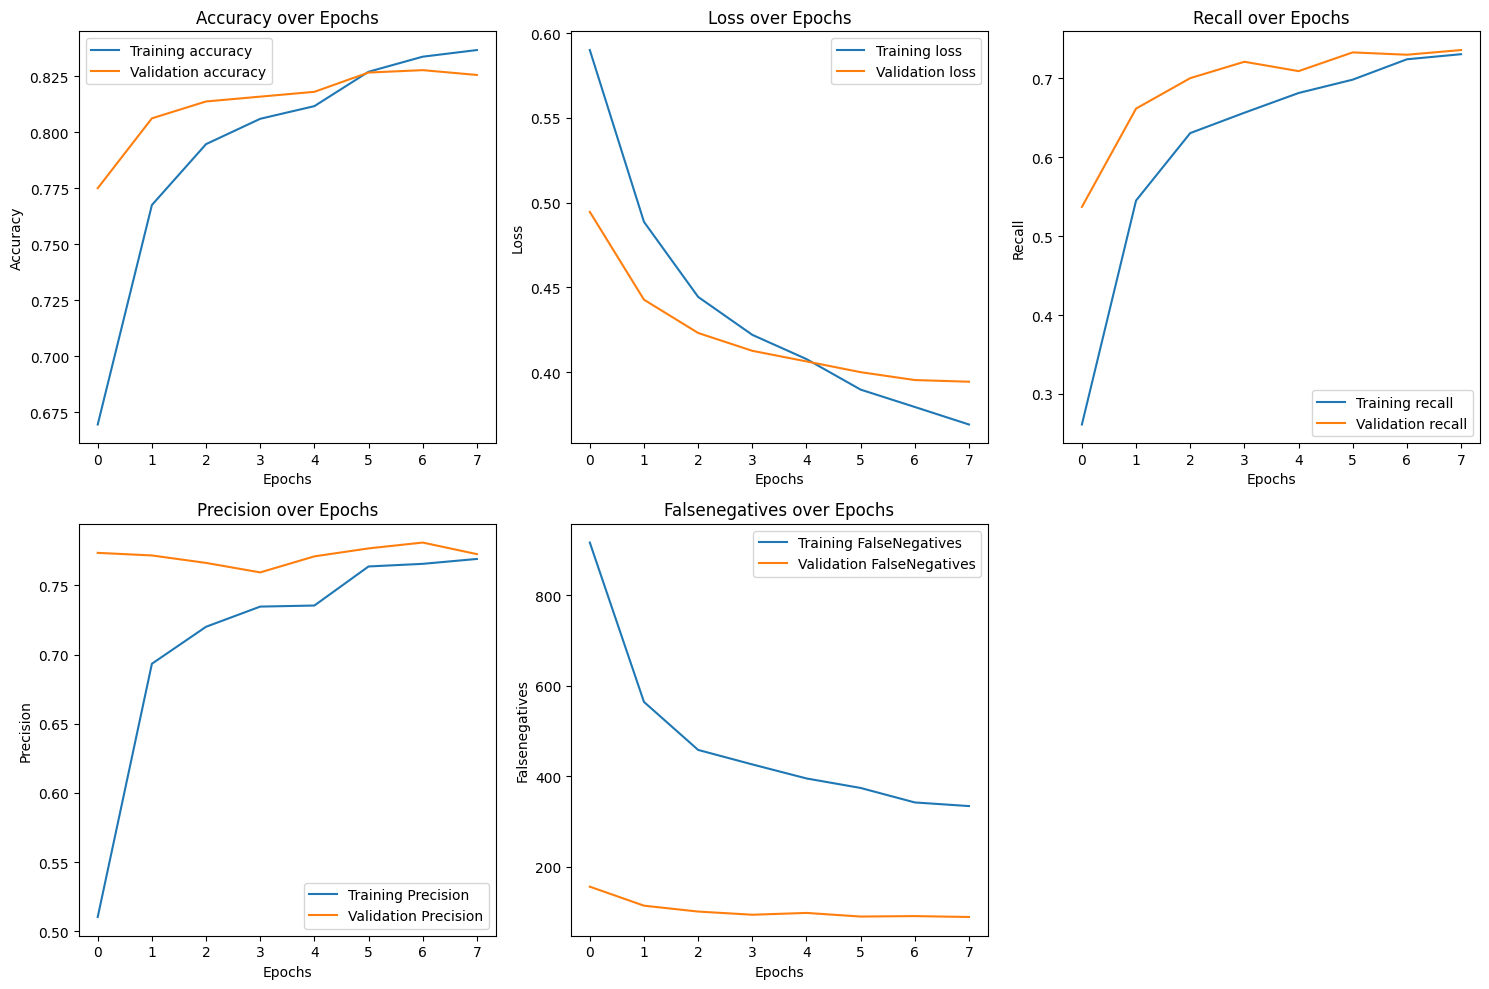

In [212]:
history_A = cnn_model.fit([train_elmo_embed_np, X_train_num], y_train,
                   epochs = 8,
                   batch_size = 16,
                   validation_split = 0.2)
plot_all_metrics(history_A)

Epoch 1/12
232/232 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - FalseNegatives: 487.3176 - Precision: 0.4727 - accuracy: 0.6507 - loss: 0.6231 - recall: 0.2126 - val_FalseNegatives: 142.0000 - val_Precision: 0.7617 - val_accuracy: 0.7815 - val_loss: 0.4840 - val_recall: 0.5786
Epoch 2/12
232/232 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - FalseNegatives: 279.4549 - Precision: 0.7181 - accuracy: 0.7754 - loss: 0.4839 - recall: 0.5503 - val_FalseNegatives: 105.0000 - val_Precision: 0.7632 - val_accuracy: 0.8095 - val_loss: 0.4443 - val_recall: 0.6884
Epoch 3/12
232/232 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - FalseNegatives: 222.3262 - Precision: 0.7195 - accuracy: 0.7951 - loss: 0.4425 - recall: 0.6422 - val_FalseNegatives: 97.0000 - val_Precision: 0.7668 - val_accuracy: 0.8170 - val_loss: 0.4279 - val_recall: 0.7122
Epoch 4/12
232/232 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - FalseNegatives: 206.0987 - Precision: 0.7454 - accuracy: 0.8131 - loss: 0.4199 - recall: 0.6760 - val_FalseNegatives: 99.0000 - val_Precision: 

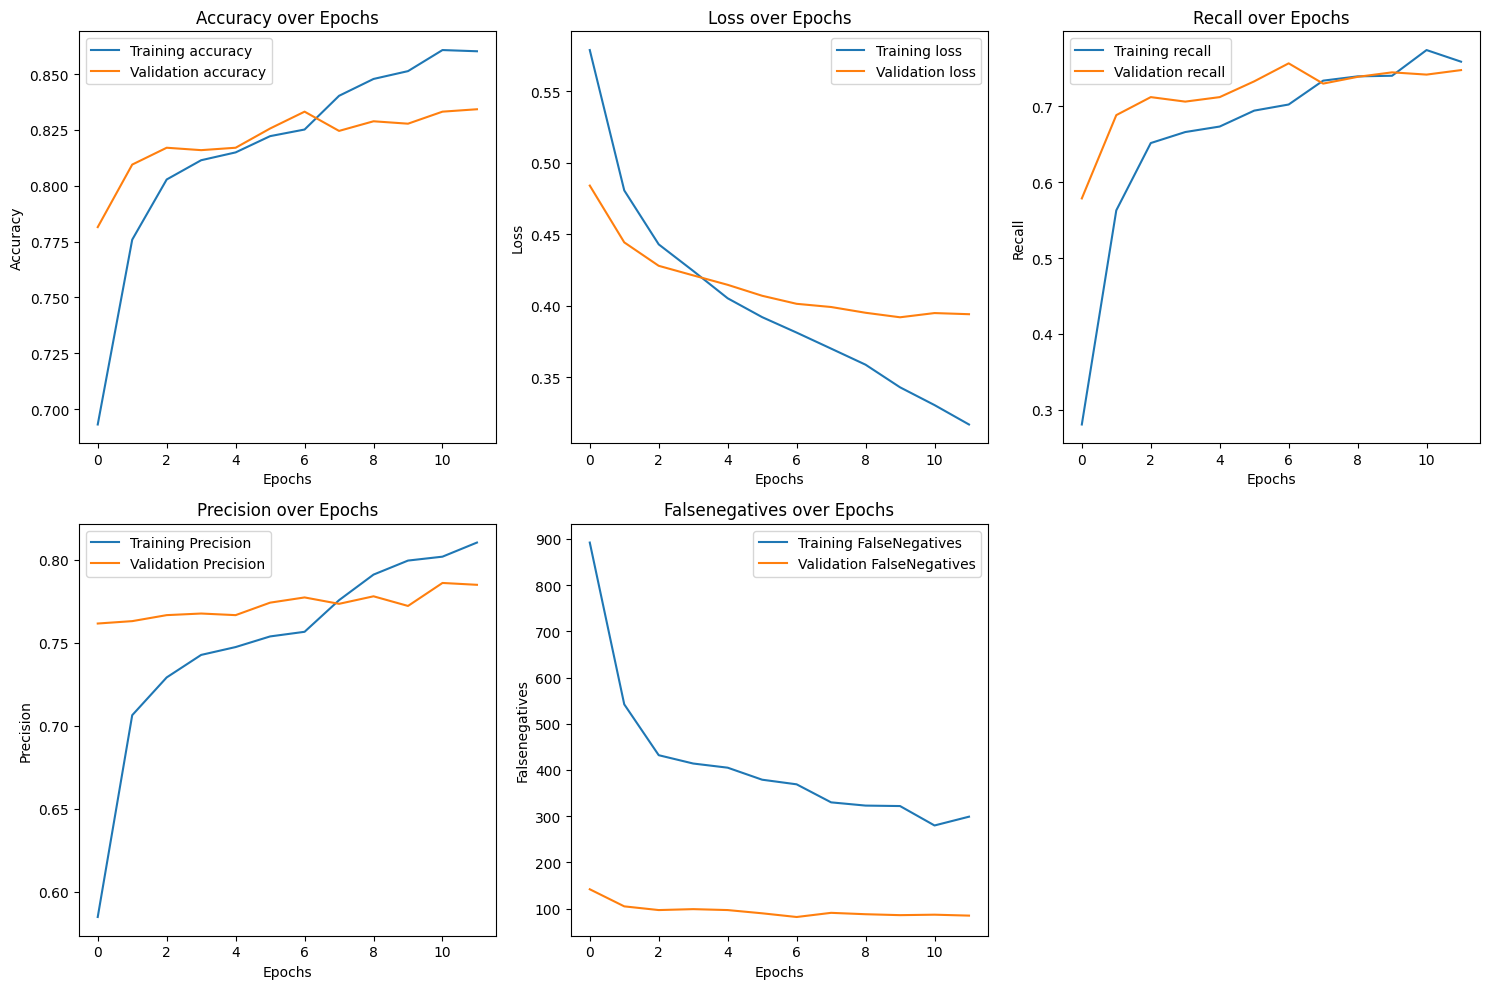

In [215]:
history_A = cnn_model.fit([train_elmo_embed_np, X_train_num], y_train,
                   epochs = 12,
                   batch_size = 16,
                   validation_split = 0.2)
plot_all_metrics(history_A)

### History for dropout 20% and 50 for combined layer LR= 0.0001 (Chosen model)

Epoch 1/12
232/232 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - FalseNegatives: 459.1888 - Precision: 0.5686 - accuracy: 0.6806 - loss: 0.5926 - recall: 0.2324 - val_FalseNegatives: 128.0000 - val_Precision: 0.7518 - val_accuracy: 0.7879 - val_loss: 0.4656 - val_recall: 0.6202
Epoch 2/12
232/232 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - FalseNegatives: 233.8755 - Precision: 0.7359 - accuracy: 0.7981 - loss: 0.4467 - recall: 0.6250 - val_FalseNegatives: 110.0000 - val_Precision: 0.7592 - val_accuracy: 0.8041 - val_loss: 0.4330 - val_recall: 0.6736
Epoch 3/12
232/232 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - FalseNegatives: 205.2103 - Precision: 0.7433 - accuracy: 0.8116 - loss: 0.4133 - recall: 0.6736 - val_FalseNegatives: 99.0000 - val_Precision: 0.7580 - val_accuracy: 0.8116 - val_loss: 0.4185 - val_recall: 0.7062
Epoch 4/12
232/232 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - FalseNegatives: 189.4506 - Precision: 0.7636 - accuracy: 0.8277 - loss: 0.3839 - recall: 0.7076 - val_FalseNegatives: 91.0000 - val_Precision: 

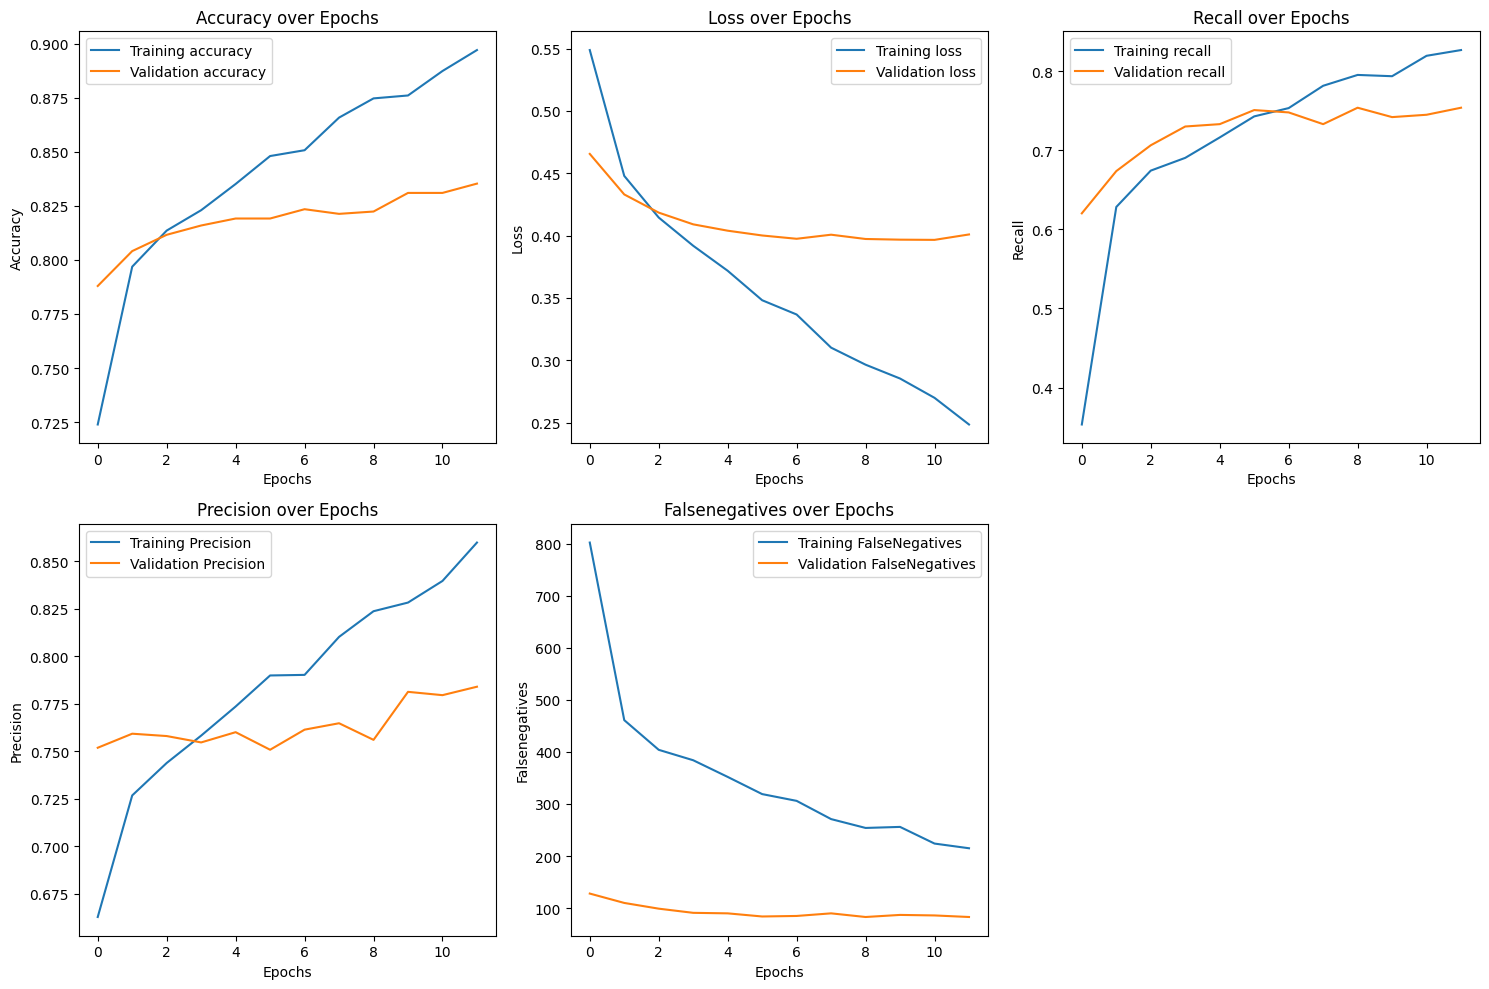

In [172]:
history_B = cnn_model.fit([train_elmo_embed_np, X_train_num], y_train,
                   epochs = 12,
                   batch_size = 16,
                   validation_split = 0.2)
plot_all_metrics(history_B)

Epoch 1/12
232/232 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - FalseNegatives: 459.1717 - Precision: 0.6349 - accuracy: 0.6945 - loss: 0.5930 - recall: 0.2417 - val_FalseNegatives: 140.0000 - val_Precision: 0.7665 - val_accuracy: 0.7847 - val_loss: 0.4645 - val_recall: 0.5846
Epoch 2/12
232/232 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - FalseNegatives: 237.7554 - Precision: 0.7256 - accuracy: 0.7933 - loss: 0.4590 - recall: 0.6219 - val_FalseNegatives: 115.0000 - val_Precision: 0.7708 - val_accuracy: 0.8052 - val_loss: 0.4279 - val_recall: 0.6588
Epoch 3/12
232/232 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - FalseNegatives: 196.3820 - Precision: 0.7471 - accuracy: 0.8187 - loss: 0.4112 - recall: 0.6982 - val_FalseNegatives: 97.0000 - val_Precision: 0.7643 - val_accuracy: 0.8159 - val_loss: 0.4112 - val_recall: 0.7122
Epoch 4/12
232/232 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - FalseNegatives: 181.1588 - Precision: 0.7685 - accuracy: 0.8321 - loss: 0.3876 - recall: 0.7183 - val_FalseNegatives: 91.0000 - val_Precision: 

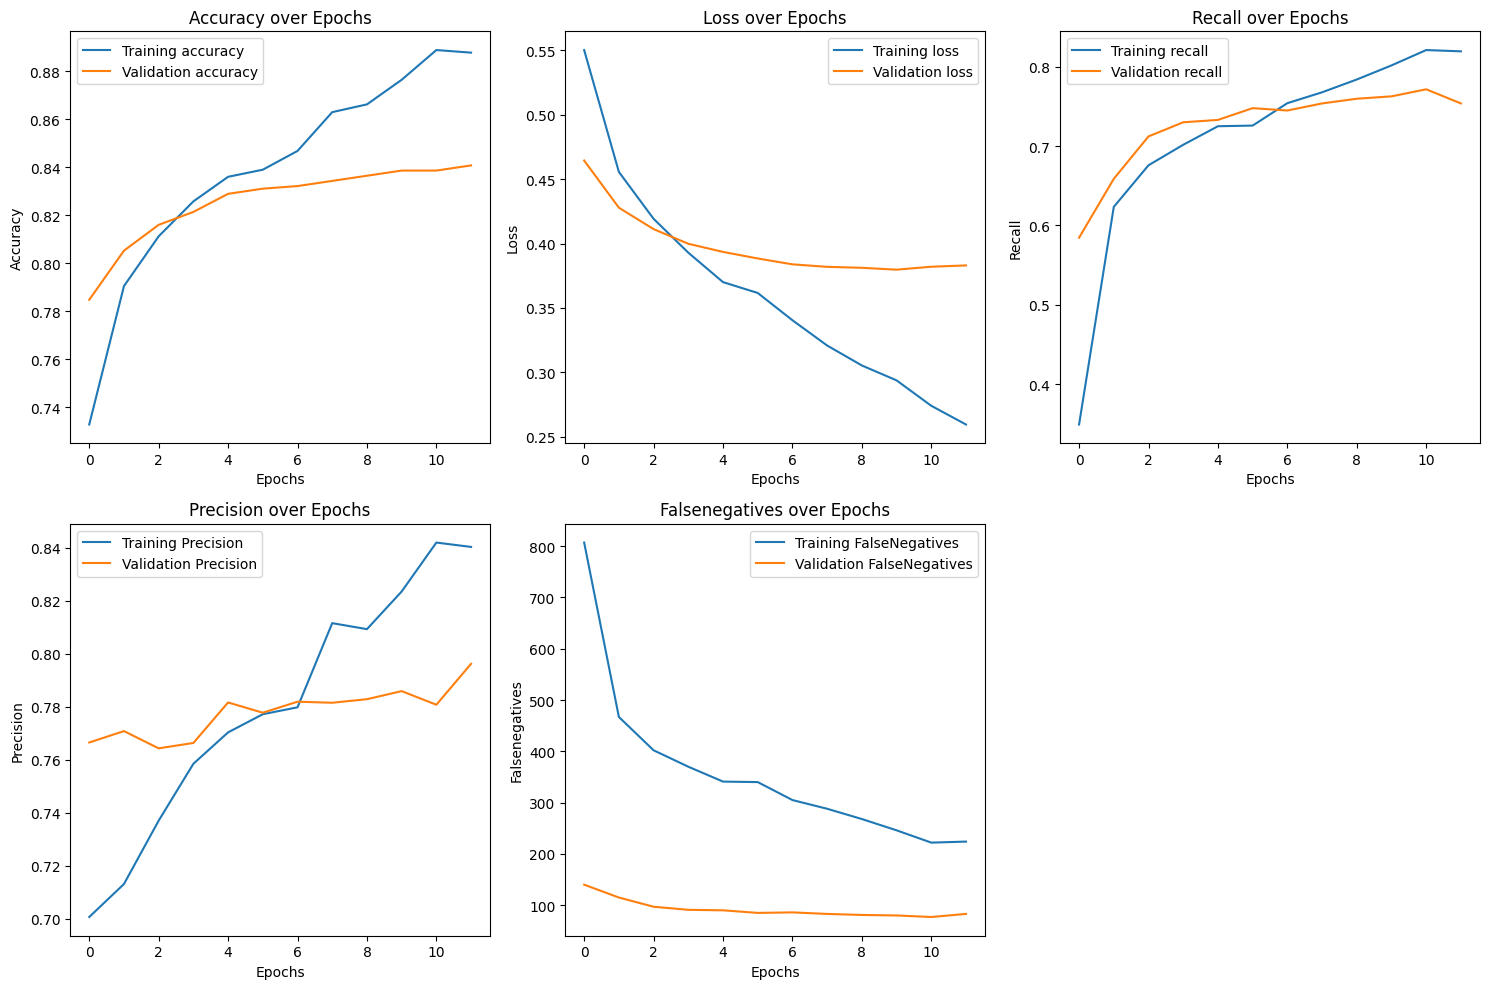

In [225]:
history_B = cnn_model.fit([train_elmo_embed_np, X_train_num], y_train,
                   epochs = 12,
                   batch_size = 16,
                   validation_split = 0.2)
plot_all_metrics(history_B)

Epoch 1/12
232/232 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - FalseNegatives: 469.8841 - Precision: 0.4884 - accuracy: 0.6493 - loss: 0.6111 - recall: 0.2429 - val_FalseNegatives: 115.0000 - val_Precision: 0.7577 - val_accuracy: 0.7998 - val_loss: 0.4649 - val_recall: 0.6588
Epoch 2/12
232/232 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - FalseNegatives: 234.3949 - Precision: 0.7464 - accuracy: 0.8038 - loss: 0.4481 - recall: 0.6327 - val_FalseNegatives: 108.0000 - val_Precision: 0.7633 - val_accuracy: 0.8073 - val_loss: 0.4302 - val_recall: 0.6795
Epoch 3/12
232/232 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - FalseNegatives: 198.7124 - Precision: 0.7527 - accuracy: 0.8186 - loss: 0.4163 - recall: 0.6878 - val_FalseNegatives: 101.0000 - val_Precision: 0.7613 - val_accuracy: 0.8116 - val_loss: 0.4150 - val_recall: 0.7003
Epoch 4/12
232/232 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - FalseNegatives: 186.3519 - Precision: 0.7667 - accuracy: 0.8299 - loss: 0.3856 - recall: 0.7119 - val_FalseNegatives: 92.0000 - val_Precision:

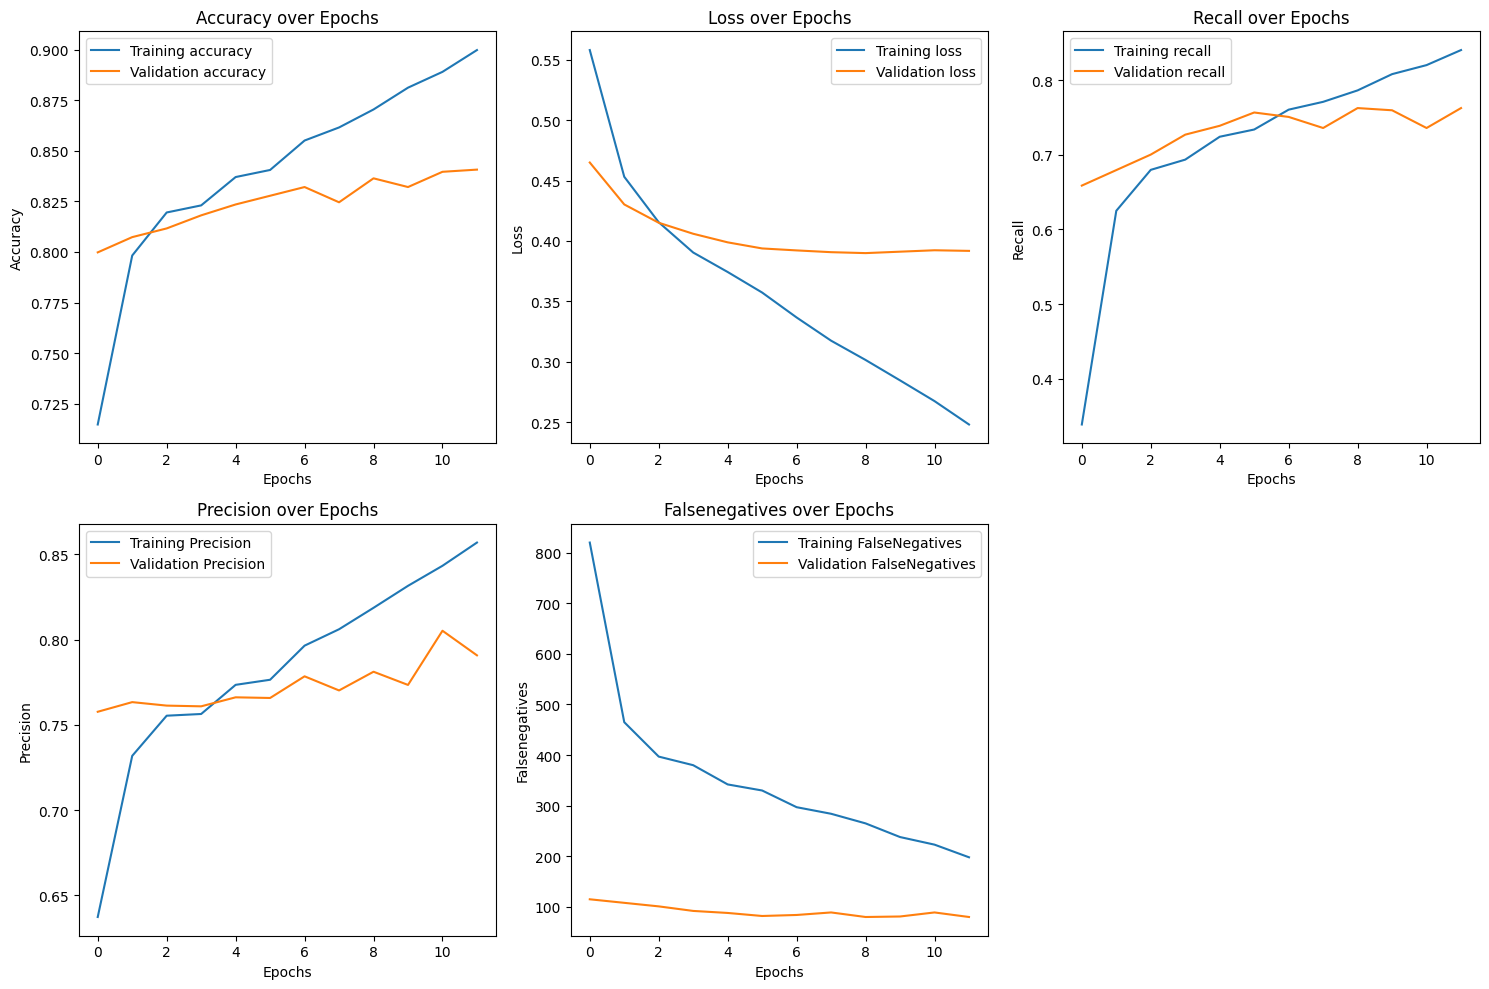

In [227]:
cnn_model = create_cnn_model(input_shape_text, input_shape_num)
history_B = cnn_model.fit([train_elmo_embed_np, X_train_num], y_train,
                   epochs = 12,
                   batch_size = 16,
                   validation_split = 0.2)
plot_all_metrics(history_B)

Epoch 1/11
232/232 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - FalseNegatives: 439.0472 - Precision: 0.6447 - accuracy: 0.7030 - loss: 0.5746 - recall: 0.2525 - val_FalseNegatives: 122.0000 - val_Precision: 0.7679 - val_accuracy: 0.7987 - val_loss: 0.4595 - val_recall: 0.6380
Epoch 2/11
232/232 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - FalseNegatives: 234.4978 - Precision: 0.7362 - accuracy: 0.7999 - loss: 0.4454 - recall: 0.6325 - val_FalseNegatives: 107.0000 - val_Precision: 0.7667 - val_accuracy: 0.8095 - val_loss: 0.4284 - val_recall: 0.6825
Epoch 3/11
232/232 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - FalseNegatives: 204.4506 - Precision: 0.7574 - accuracy: 0.8197 - loss: 0.4107 - recall: 0.6838 - val_FalseNegatives: 97.0000 - val_Precision: 0.7547 - val_accuracy: 0.8116 - val_loss: 0.4136 - val_recall: 0.7122
Epoch 4/11
232/232 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - FalseNegatives: 193.9270 - Precision: 0.7568 - accuracy: 0.8233 - loss: 0.3861 - recall: 0.7009 - val_FalseNegatives: 94.0000 - val_Precision: 

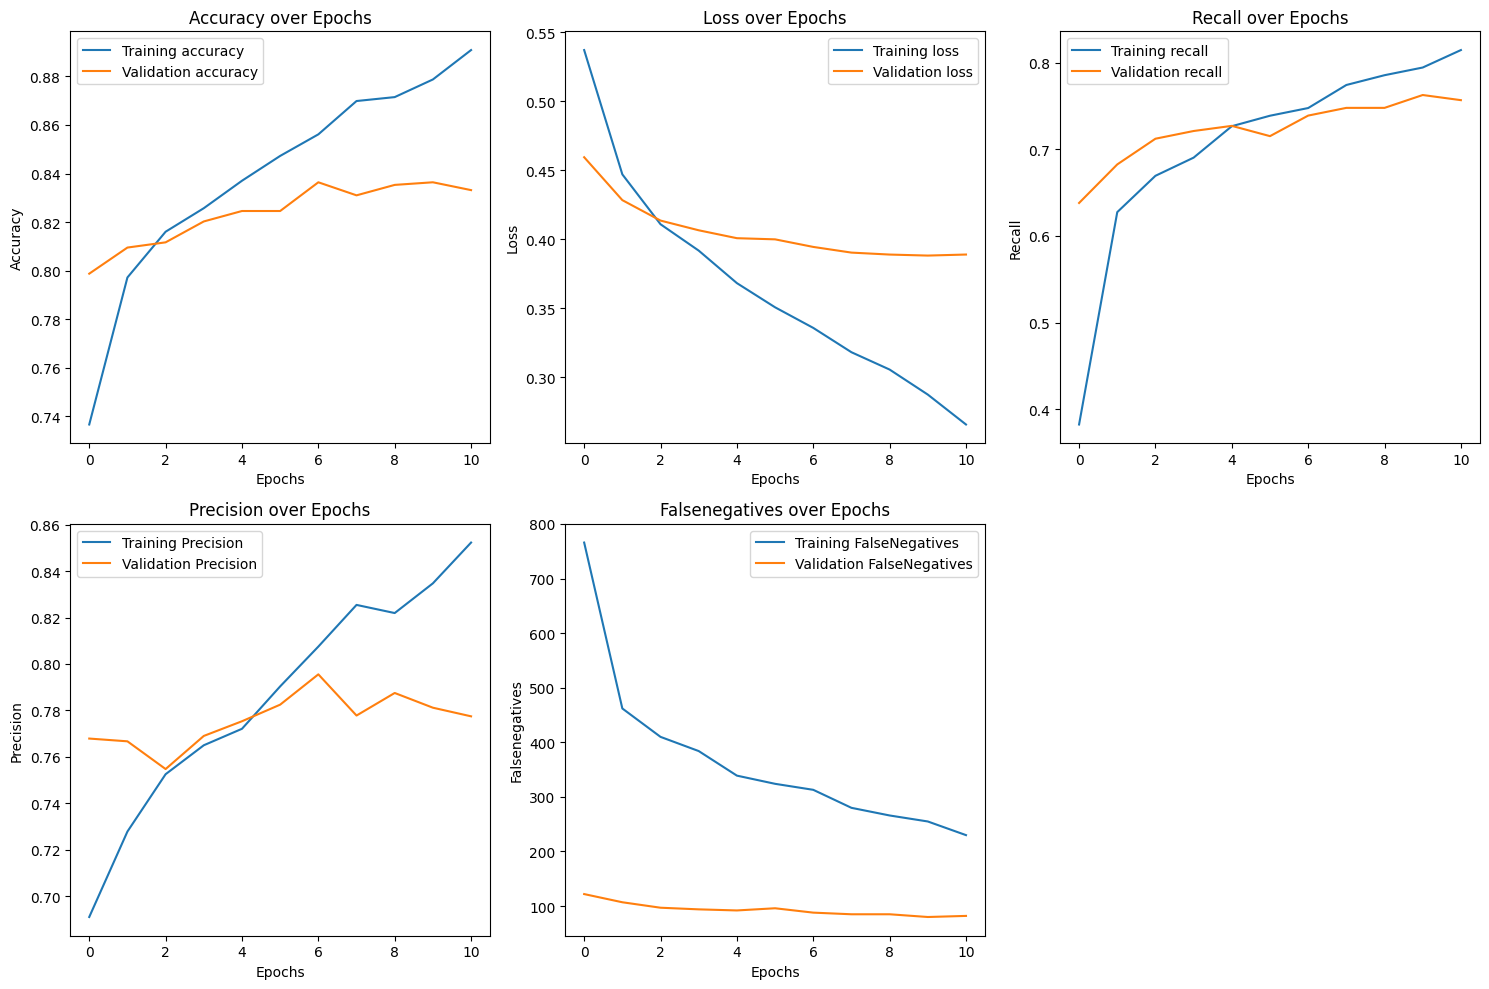

In [232]:
cnn_model = create_cnn_model(input_shape_text, input_shape_num)
history_B = cnn_model.fit([train_elmo_embed_np, X_train_num], y_train,
                   epochs = 11,
                   batch_size = 16,
                   validation_split = 0.2)
plot_all_metrics(history_B)

Epoch 1/11
232/232 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - FalseNegatives: 445.7210 - Precision: 0.4748 - accuracy: 0.6351 - loss: 0.6287 - recall: 0.3120 - val_FalseNegatives: 134.0000 - val_Precision: 0.7719 - val_accuracy: 0.7912 - val_loss: 0.4573 - val_recall: 0.6024
Epoch 2/11
232/232 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - FalseNegatives: 238.6824 - Precision: 0.7051 - accuracy: 0.7852 - loss: 0.4627 - recall: 0.6228 - val_FalseNegatives: 105.0000 - val_Precision: 0.7708 - val_accuracy: 0.8127 - val_loss: 0.4214 - val_recall: 0.6884
Epoch 3/11
232/232 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - FalseNegatives: 212.8369 - Precision: 0.7361 - accuracy: 0.8069 - loss: 0.4190 - recall: 0.6657 - val_FalseNegatives: 96.0000 - val_Precision: 0.7724 - val_accuracy: 0.8202 - val_loss: 0.4075 - val_recall: 0.7151
Epoch 4/11
232/232 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - FalseNegatives: 191.7511 - Precision: 0.7540 - accuracy: 0.8212 - loss: 0.3988 - recall: 0.6968 - val_FalseNegatives: 93.0000 - val_Precision: 

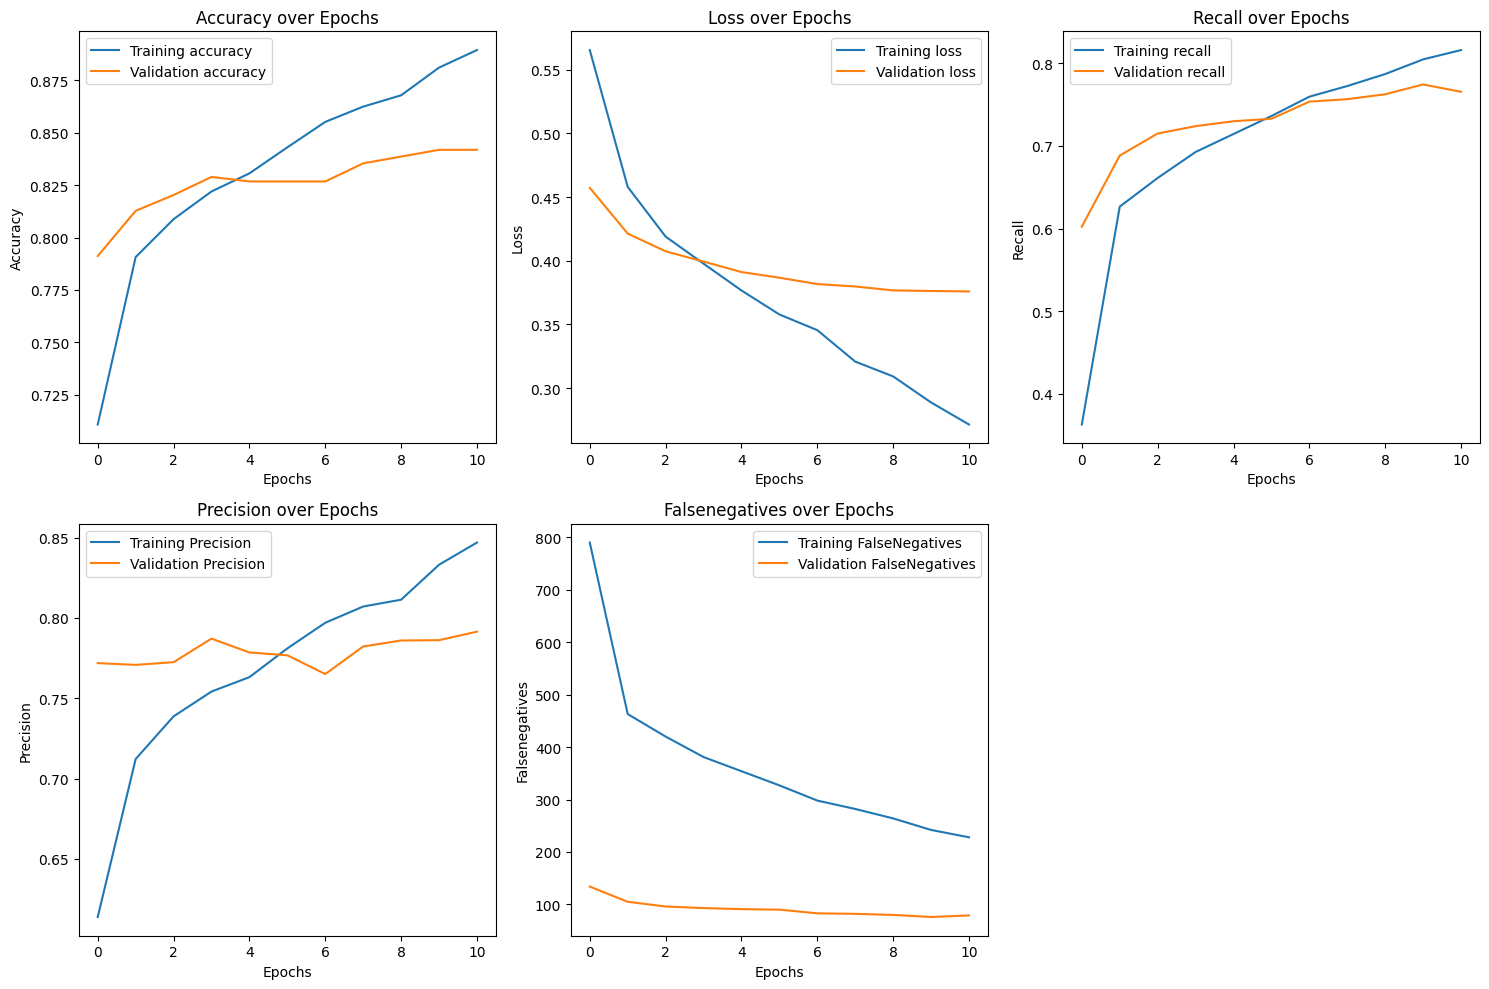

In [240]:
cnn_model = create_cnn_model(input_shape_text, input_shape_num)
history_B = cnn_model.fit([train_elmo_embed_np, X_train_num], y_train,
                   epochs = 11,
                   batch_size = 16,
                   validation_split = 0.2)
plot_all_metrics(history_B)

Epoch 1/10
232/232 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - FalseNegatives: 482.9356 - Precision: 0.5274 - accuracy: 0.6697 - loss: 0.6013 - recall: 0.2013 - val_FalseNegatives: 134.0000 - val_Precision: 0.7778 - val_accuracy: 0.7933 - val_loss: 0.4641 - val_recall: 0.6024
Epoch 2/10
232/232 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - FalseNegatives: 257.1888 - Precision: 0.7261 - accuracy: 0.7859 - loss: 0.4518 - recall: 0.5869 - val_FalseNegatives: 104.0000 - val_Precision: 0.7639 - val_accuracy: 0.8105 - val_loss: 0.4273 - val_recall: 0.6914
Epoch 3/10
232/232 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - FalseNegatives: 210.2489 - Precision: 0.7550 - accuracy: 0.8151 - loss: 0.4097 - recall: 0.6688 - val_FalseNegatives: 97.0000 - val_Precision: 0.7692 - val_accuracy: 0.8181 - val_loss: 0.4126 - val_recall: 0.7122
Epoch 4/10
232/232 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - FalseNegatives: 186.7940 - Precision: 0.7681 - accuracy: 0.8305 - loss: 0.3854 - recall: 0.7125 - val_FalseNegatives: 93.0000 - val_Precision: 

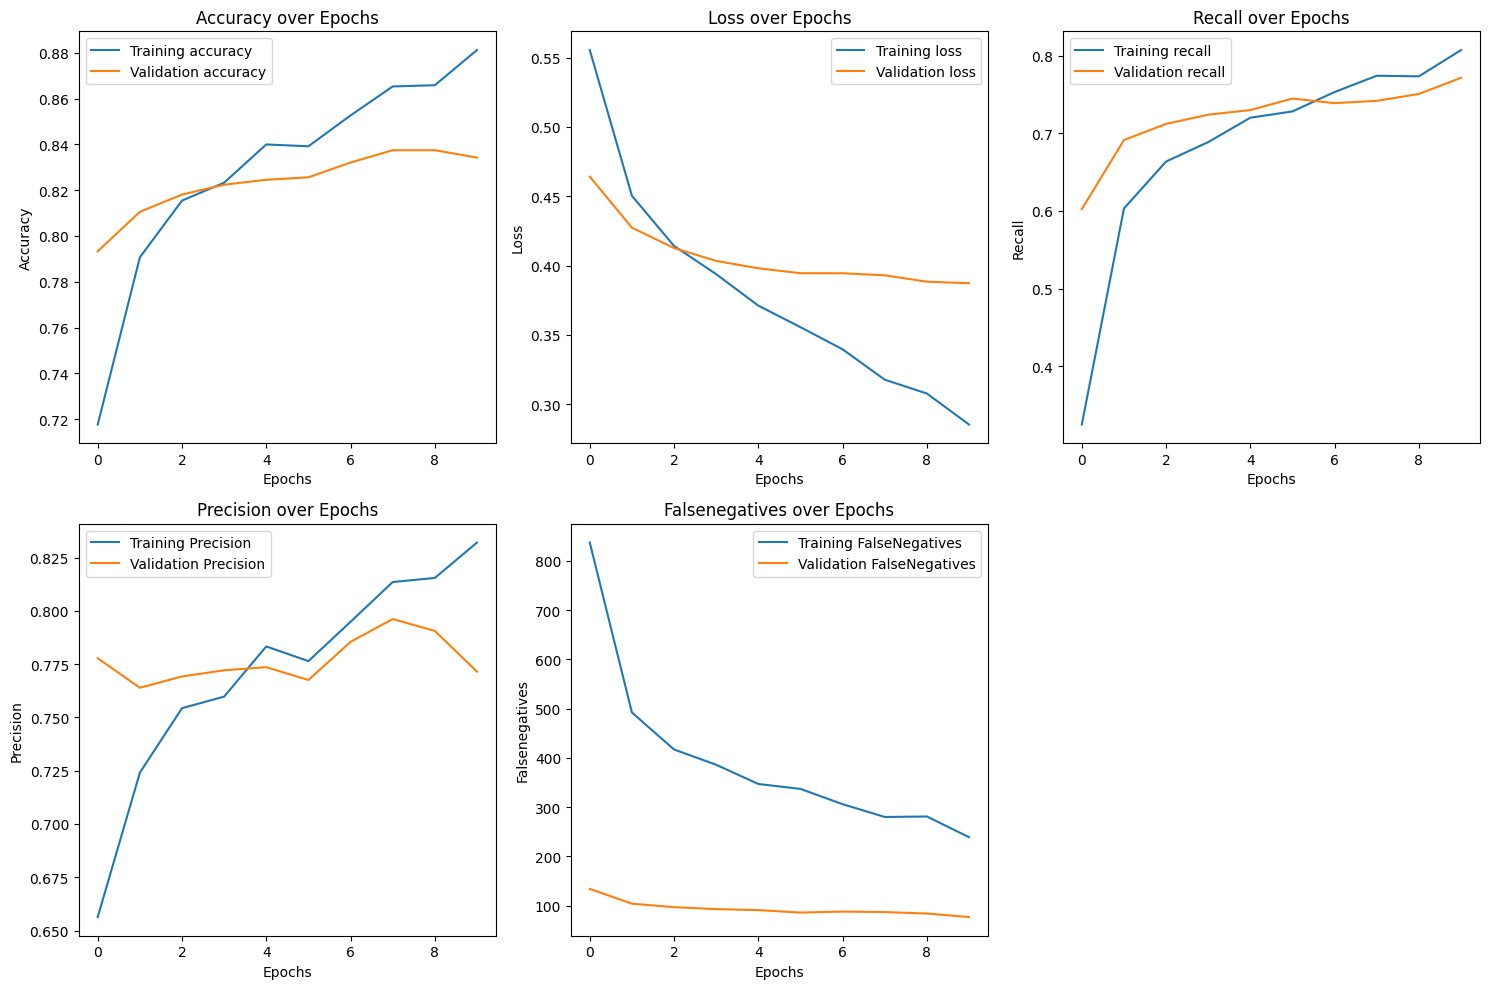

In [233]:
cnn_model = create_cnn_model(input_shape_text, input_shape_num)
history_B = cnn_model.fit([train_elmo_embed_np, X_train_num], y_train,
                   epochs = 10,
                   batch_size = 16,
                   validation_split = 0.2)
plot_all_metrics(history_B)

Epoch 1/10
232/232 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - FalseNegatives: 410.4034 - Precision: 0.5176 - accuracy: 0.6523 - loss: 0.6197 - recall: 0.3795 - val_FalseNegatives: 143.0000 - val_Precision: 0.7698 - val_accuracy: 0.7836 - val_loss: 0.4676 - val_recall: 0.5757
Epoch 2/10
232/232 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - FalseNegatives: 244.7897 - Precision: 0.7263 - accuracy: 0.7899 - loss: 0.4593 - recall: 0.6053 - val_FalseNegatives: 101.0000 - val_Precision: 0.7638 - val_accuracy: 0.8127 - val_loss: 0.4284 - val_recall: 0.7003
Epoch 3/10
232/232 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - FalseNegatives: 202.0086 - Precision: 0.7384 - accuracy: 0.8117 - loss: 0.4119 - recall: 0.6838 - val_FalseNegatives: 99.0000 - val_Precision: 0.7628 - val_accuracy: 0.8138 - val_loss: 0.4141 - val_recall: 0.7062
Epoch 4/10
232/232 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - FalseNegatives: 190.6867 - Precision: 0.7515 - accuracy: 0.8216 - loss: 0.3882 - recall: 0.7030 - val_FalseNegatives: 92.0000 - val_Precision: 

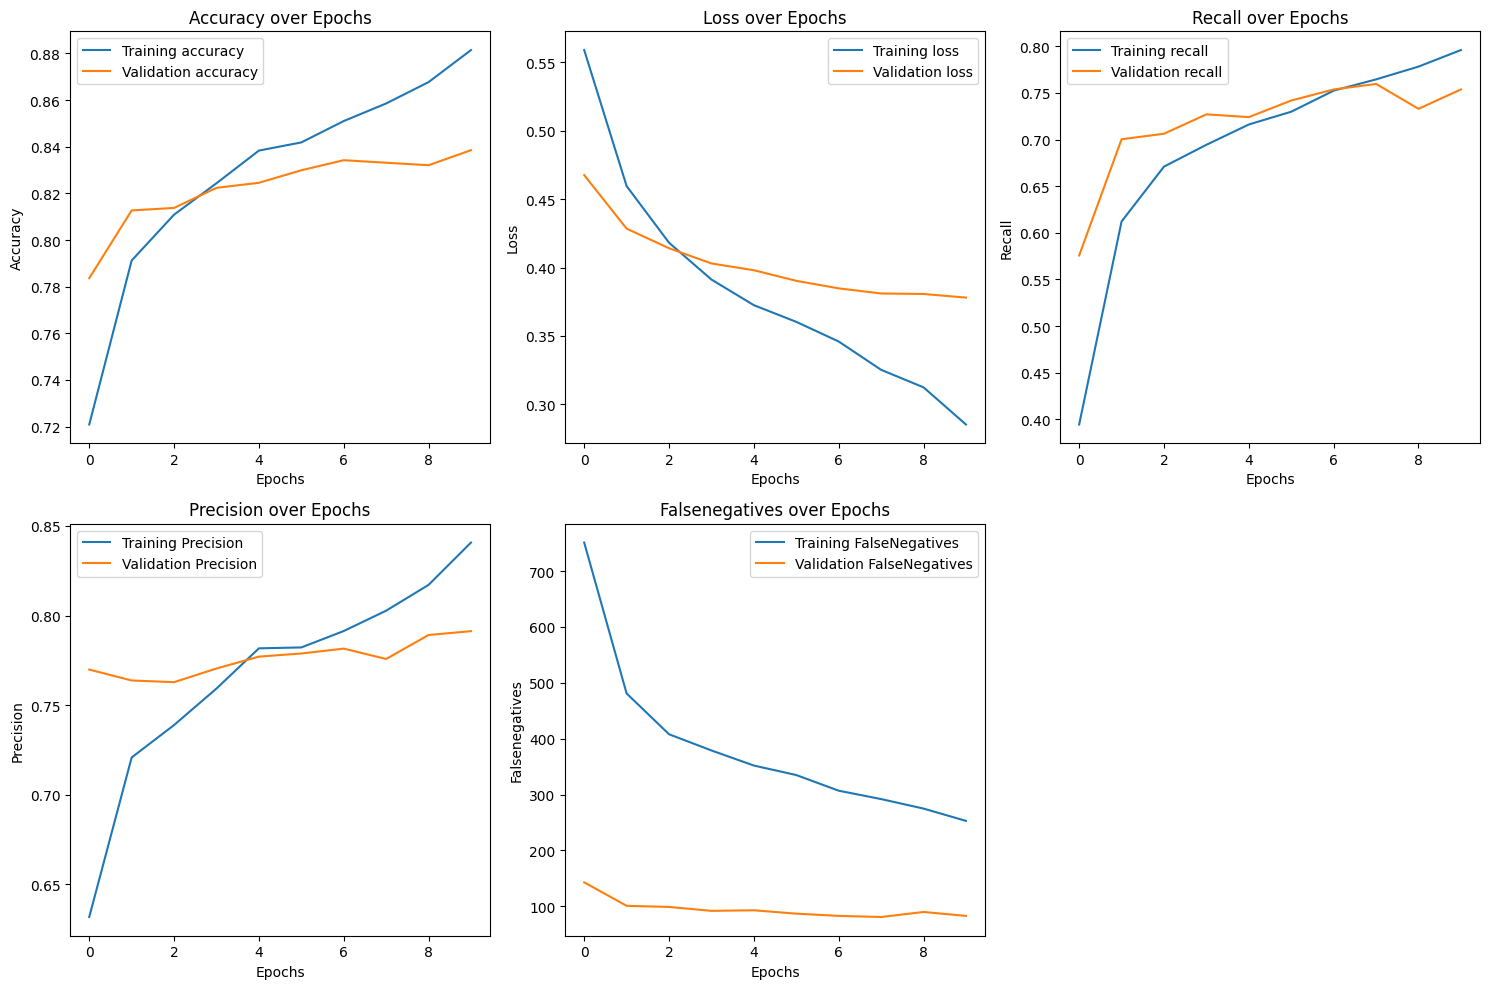

In [234]:
cnn_model = create_cnn_model(input_shape_text, input_shape_num)
history_B = cnn_model.fit([train_elmo_embed_np, X_train_num], y_train,
                   epochs = 10,
                   batch_size = 16,
                   validation_split = 0.2)
plot_all_metrics(history_B)

Epoch 1/11
232/232 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - FalseNegatives: 472.7596 - Precision: 0.4914 - accuracy: 0.6546 - loss: 0.6119 - recall: 0.2405 - val_FalseNegatives: 135.0000 - val_Precision: 0.7710 - val_accuracy: 0.7901 - val_loss: 0.4654 - val_recall: 0.5994
Epoch 2/11
232/232 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - FalseNegatives: 241.4421 - Precision: 0.7359 - accuracy: 0.7962 - loss: 0.4568 - recall: 0.6172 - val_FalseNegatives: 110.0000 - val_Precision: 0.7669 - val_accuracy: 0.8073 - val_loss: 0.4273 - val_recall: 0.6736
Epoch 3/11
232/232 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - FalseNegatives: 196.9571 - Precision: 0.7549 - accuracy: 0.8201 - loss: 0.4197 - recall: 0.6901 - val_FalseNegatives: 102.0000 - val_Precision: 0.7630 - val_accuracy: 0.8116 - val_loss: 0.4118 - val_recall: 0.6973
Epoch 4/11
232/232 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - FalseNegatives: 189.0644 - Precision: 0.7725 - accuracy: 0.8319 - loss: 0.3911 - recall: 0.7100 - val_FalseNegatives: 98.0000 - val_Precision:

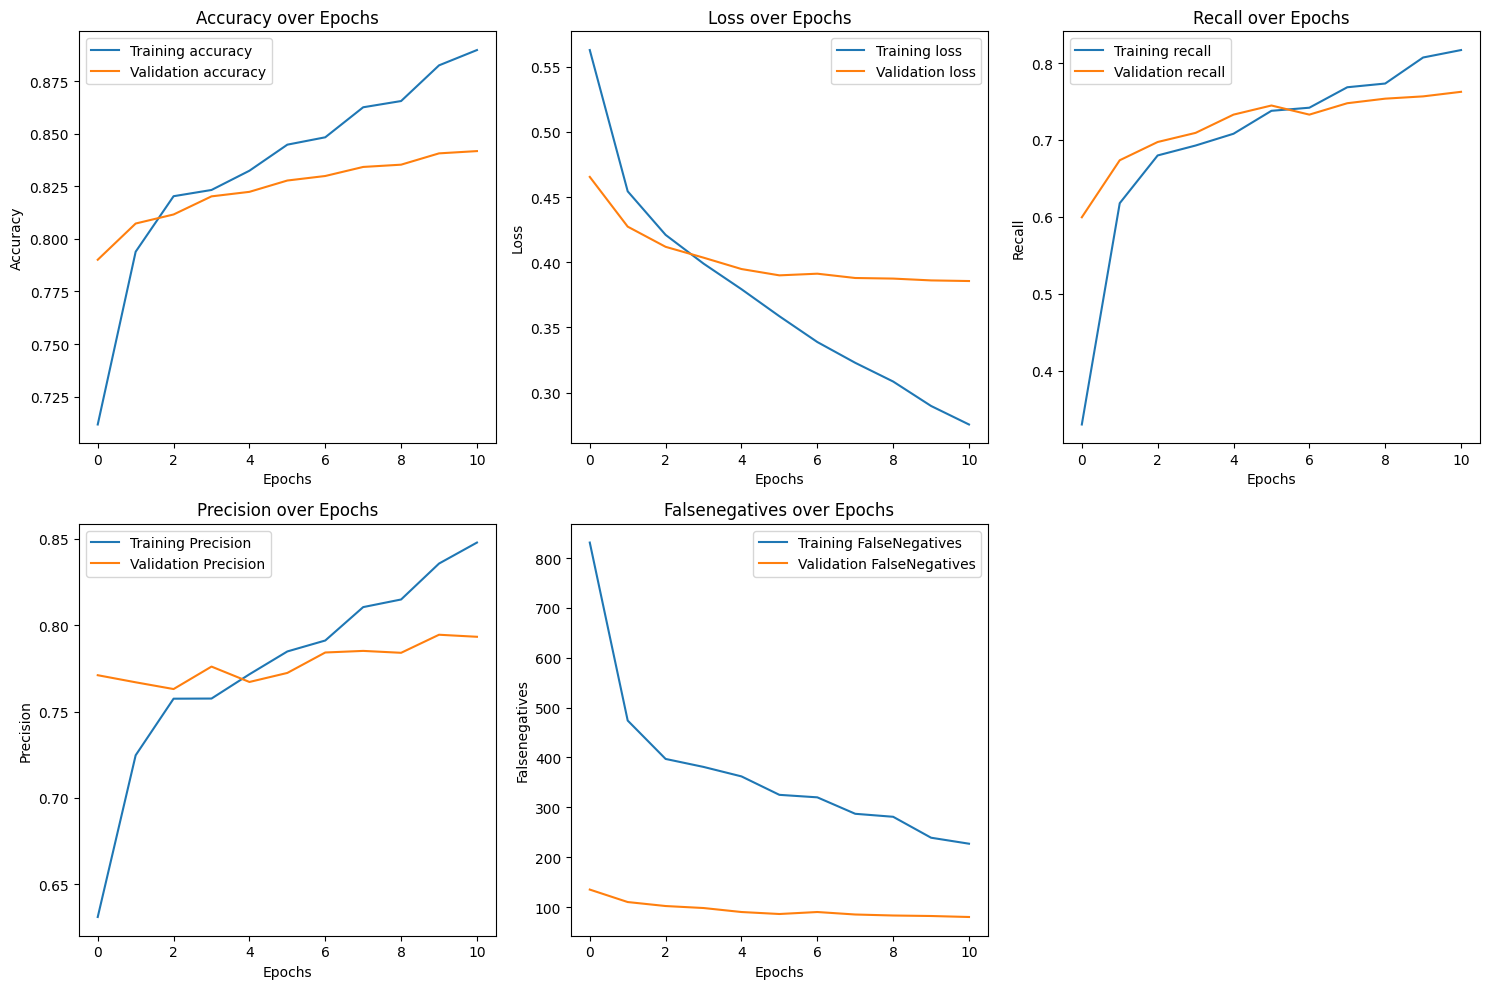

In [235]:
cnn_model = create_cnn_model(input_shape_text, input_shape_num)
history_B = cnn_model.fit([train_elmo_embed_np, X_train_num], y_train,
                   epochs = 11,
                   batch_size = 16,
                   validation_split = 0.2)
plot_all_metrics(history_B)

Epoch 1/7
232/232 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - FalseNegatives: 430.8712 - Precision: 0.4647 - accuracy: 0.6235 - loss: 0.6308 - recall: 0.3467 - val_FalseNegatives: 156.0000 - val_Precision: 0.7702 - val_accuracy: 0.7740 - val_loss: 0.4705 - val_recall: 0.5371
Epoch 2/7
232/232 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - FalseNegatives: 244.2403 - Precision: 0.7337 - accuracy: 0.7941 - loss: 0.4581 - recall: 0.6116 - val_FalseNegatives: 109.0000 - val_Precision: 0.7651 - val_accuracy: 0.8073 - val_loss: 0.4277 - val_recall: 0.6766
Epoch 3/7
232/232 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - FalseNegatives: 210.0258 - Precision: 0.7440 - accuracy: 0.8121 - loss: 0.4196 - recall: 0.6741 - val_FalseNegatives: 96.0000 - val_Precision: 0.7627 - val_accuracy: 0.8159 - val_loss: 0.4124 - val_recall: 0.7151
Epoch 4/7
232/232 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - FalseNegatives: 191.3176 - Precision: 0.7633 - accuracy: 0.8271 - loss: 0.3929 - recall: 0.7057 - val_FalseNegatives: 95.0000 - val_Precision: 0.77

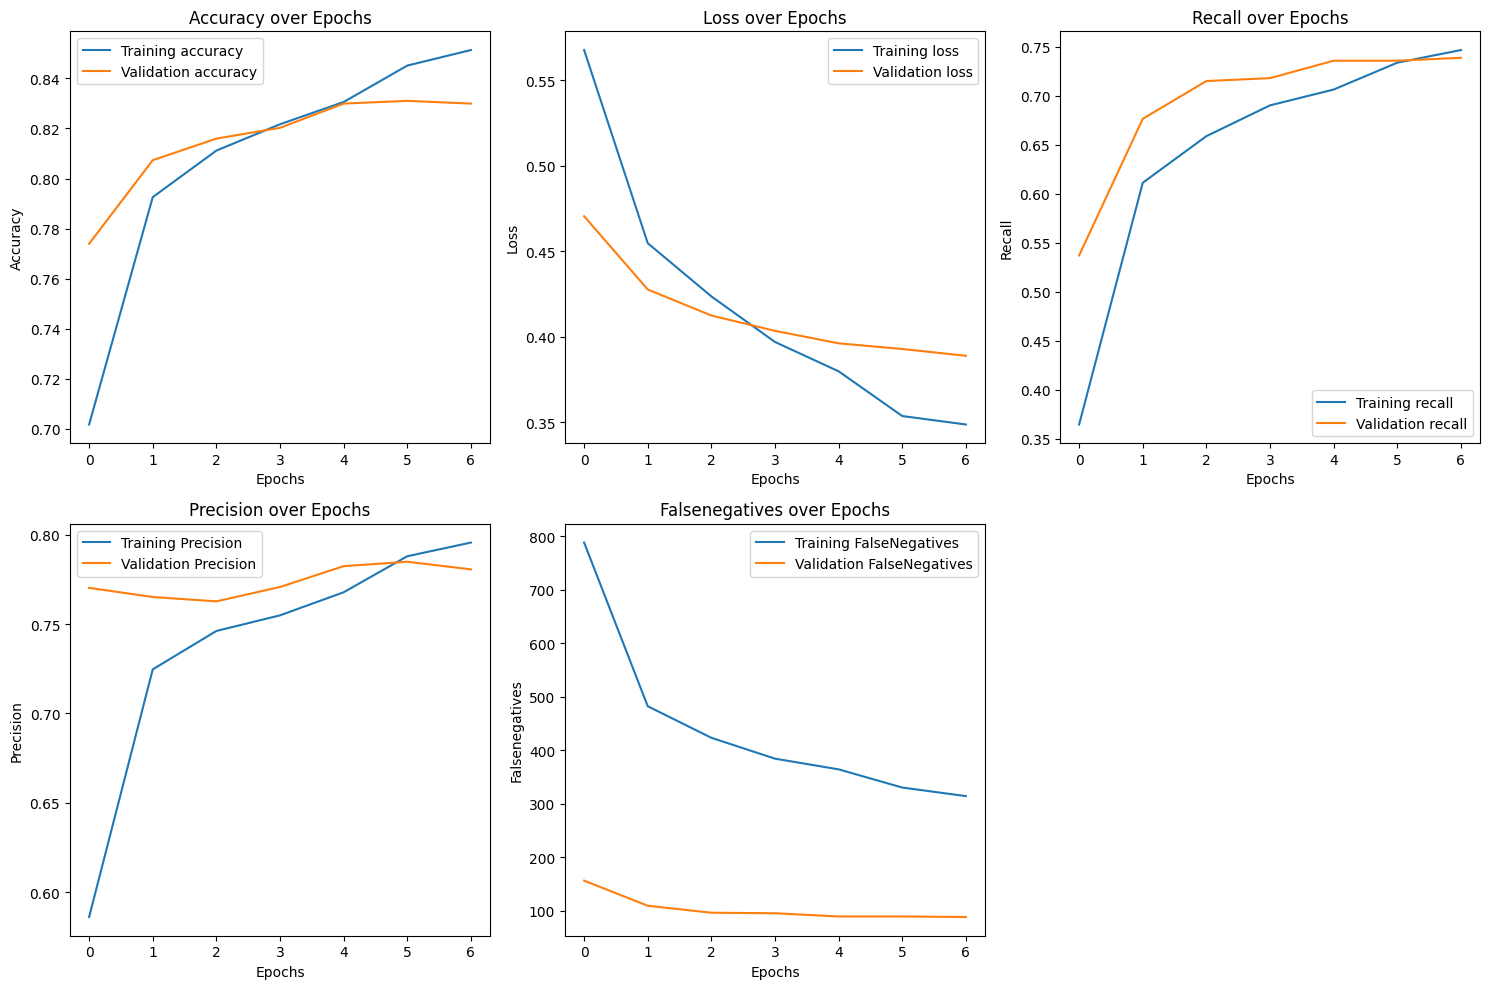

In [175]:
history_B = cnn_model.fit([train_elmo_embed_np, X_train_num], y_train,
                   epochs = 7,
                   batch_size = 16,
                   validation_split = 0.2)
plot_all_metrics(history_B)

Epoch 1/12
232/232 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - FalseNegatives: 437.8412 - Precision: 0.5353 - accuracy: 0.6694 - loss: 0.6027 - recall: 0.2989 - val_FalseNegatives: 125.0000 - val_Precision: 0.7491 - val_accuracy: 0.7890 - val_loss: 0.4573 - val_recall: 0.6291
Epoch 2/12
232/232 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - FalseNegatives: 232.0000 - Precision: 0.7346 - accuracy: 0.7991 - loss: 0.4446 - recall: 0.6324 - val_FalseNegatives: 104.0000 - val_Precision: 0.7664 - val_accuracy: 0.8116 - val_loss: 0.4232 - val_recall: 0.6914
Epoch 3/12
232/232 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - FalseNegatives: 206.8326 - Precision: 0.7533 - accuracy: 0.8163 - loss: 0.4152 - recall: 0.6769 - val_FalseNegatives: 101.0000 - val_Precision: 0.7763 - val_accuracy: 0.8181 - val_loss: 0.4095 - val_recall: 0.7003
Epoch 4/12
232/232 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - FalseNegatives: 186.3176 - Precision: 0.7639 - accuracy: 0.8279 - loss: 0.3886 - recall: 0.7084 - val_FalseNegatives: 95.0000 - val_Precision:

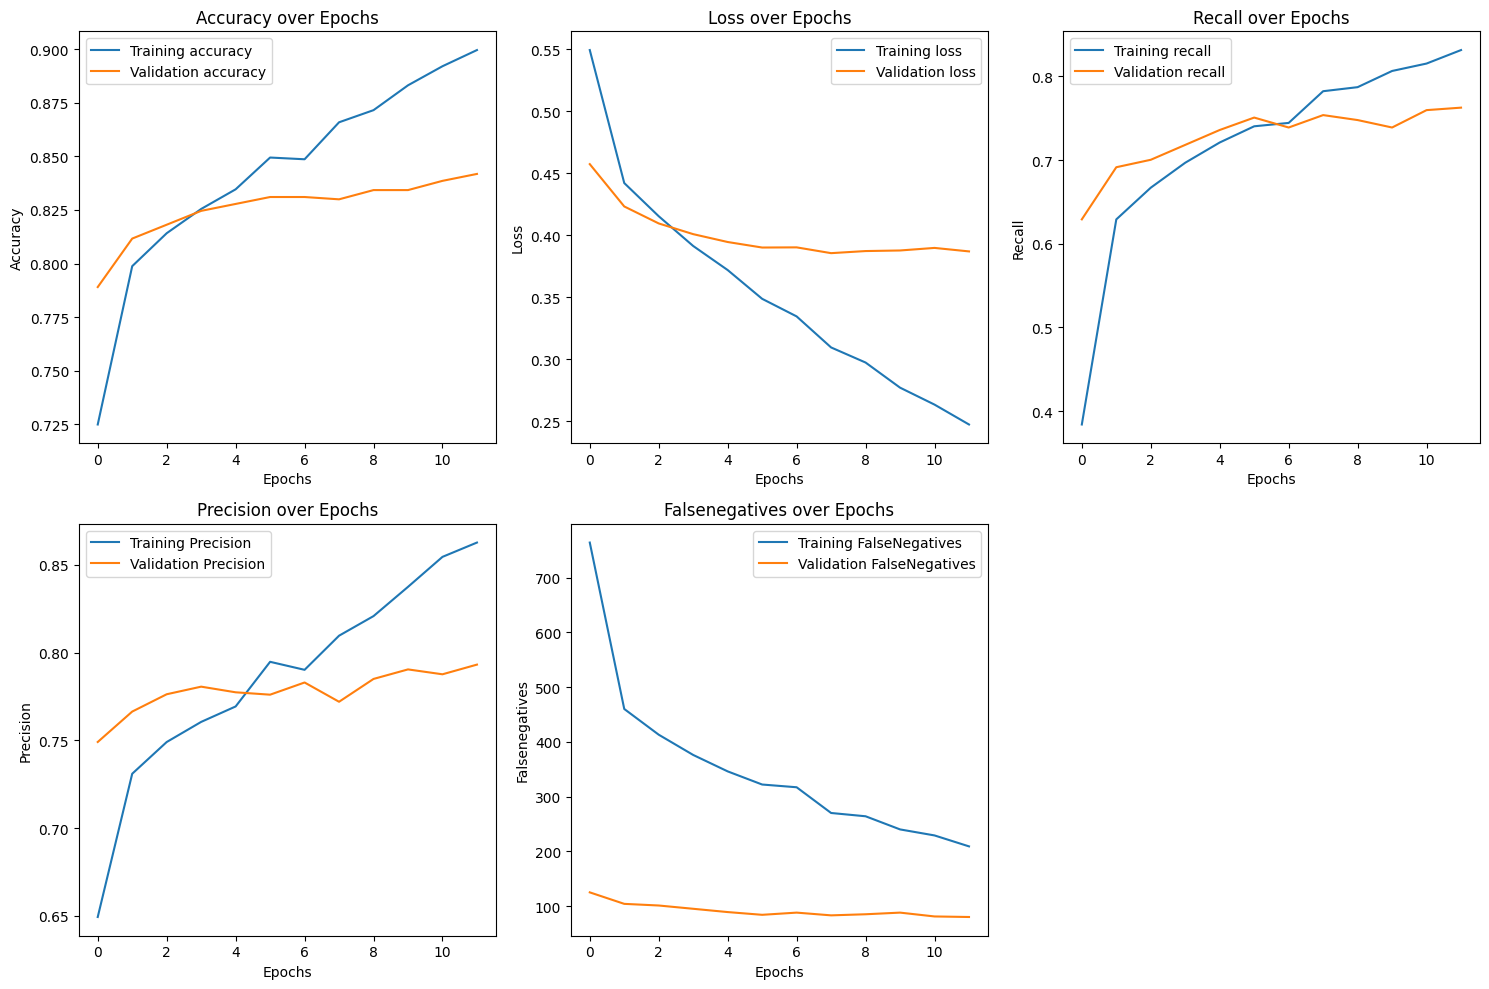

In [228]:
cnn_model = create_cnn_model(input_shape_text, input_shape_num)
history_B = cnn_model.fit([train_elmo_embed_np, X_train_num], y_train,
                   epochs = 12,
                   batch_size = 16,
                   validation_split = 0.2)
plot_all_metrics(history_B)

### History for dropout 20% and 50 for combined layer LR= 0.001

Epoch 1/12
232/232 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - FalseNegatives: 260.5880 - Precision: 0.6547 - accuracy: 0.7505 - loss: 0.5093 - recall: 0.5304 - val_FalseNegatives: 100.0000 - val_Precision: 0.7548 - val_accuracy: 0.8095 - val_loss: 0.4105 - val_recall: 0.7033
Epoch 2/12
232/232 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - FalseNegatives: 176.1545 - Precision: 0.7541 - accuracy: 0.8265 - loss: 0.3830 - recall: 0.7212 - val_FalseNegatives: 98.0000 - val_Precision: 0.7685 - val_accuracy: 0.8170 - val_loss: 0.4113 - val_recall: 0.7092
Epoch 3/12
232/232 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - FalseNegatives: 158.6953 - Precision: 0.7720 - accuracy: 0.8419 - loss: 0.3445 - recall: 0.7537 - val_FalseNegatives: 83.0000 - val_Precision: 0.7449 - val_accuracy: 0.8170 - val_loss: 0.3963 - val_recall: 0.7537
Epoch 4/12
232/232 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - FalseNegatives: 131.1974 - Precision: 0.8067 - accuracy: 0.8678 - loss: 0.2968 - recall: 0.7994 - val_FalseNegatives: 91.0000 - val_Precision: 0

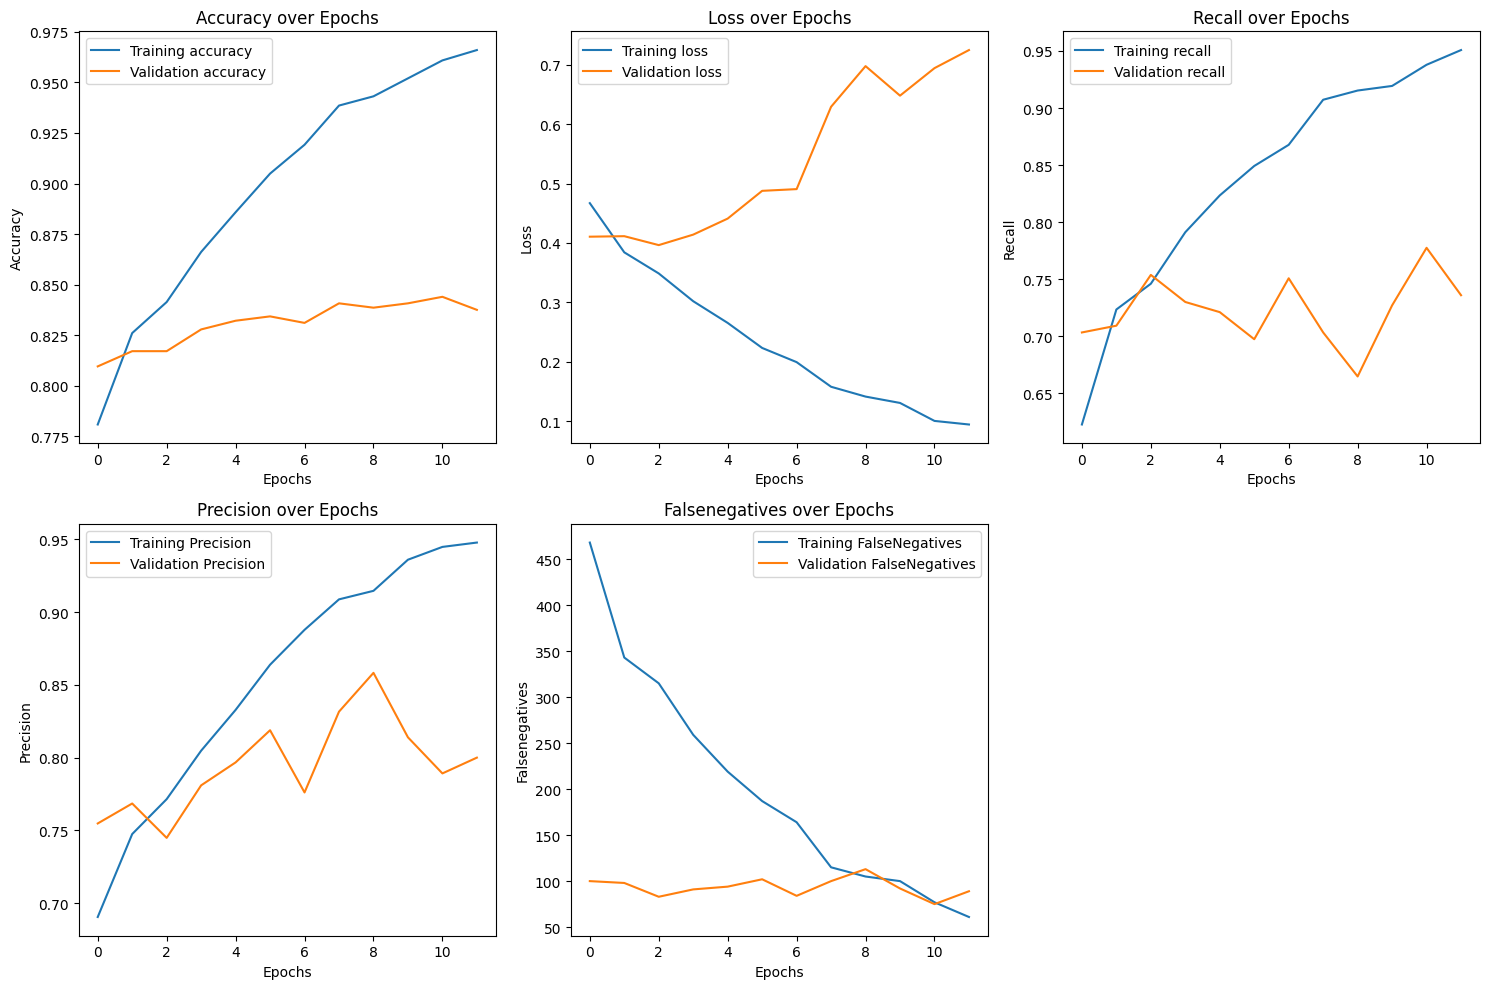

In [230]:
cnn_model = create_cnn_model(input_shape_text, input_shape_num)
history_C = cnn_model.fit([train_elmo_embed_np, X_train_num], y_train,
                   epochs = 12,
                   batch_size = 16,
                   validation_split = 0.2)
plot_all_metrics(history_C)

Epoch 1/12
232/232 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - FalseNegatives: 10.1459 - Precision: 0.9886 - accuracy: 0.9907 - loss: 0.0315 - recall: 0.9837 - val_FalseNegatives: 70.0000 - val_Precision: 0.7295 - val_accuracy: 0.8181 - val_loss: 1.5478 - val_recall: 0.7923
Epoch 2/12
232/232 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - FalseNegatives: 15.8927 - Precision: 0.9765 - accuracy: 0.9827 - loss: 0.0515 - recall: 0.9721 - val_FalseNegatives: 91.0000 - val_Precision: 0.7935 - val_accuracy: 0.8332 - val_loss: 1.1929 - val_recall: 0.7300
Epoch 3/12
232/232 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - FalseNegatives: 3.0601 - Precision: 0.9974 - accuracy: 0.9974 - loss: 0.0086 - recall: 0.9949 - val_FalseNegatives: 86.0000 - val_Precision: 0.7844 - val_accuracy: 0.8332 - val_loss: 1.4373 - val_recall: 0.7448
Epoch 4/12
232/232 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - FalseNegatives: 4.5279 - Precision: 0.9917 - accuracy: 0.9953 - loss: 0.0136 - recall: 0.9943 - val_FalseNegatives: 83.0000 - val_Precision: 0.7697 -

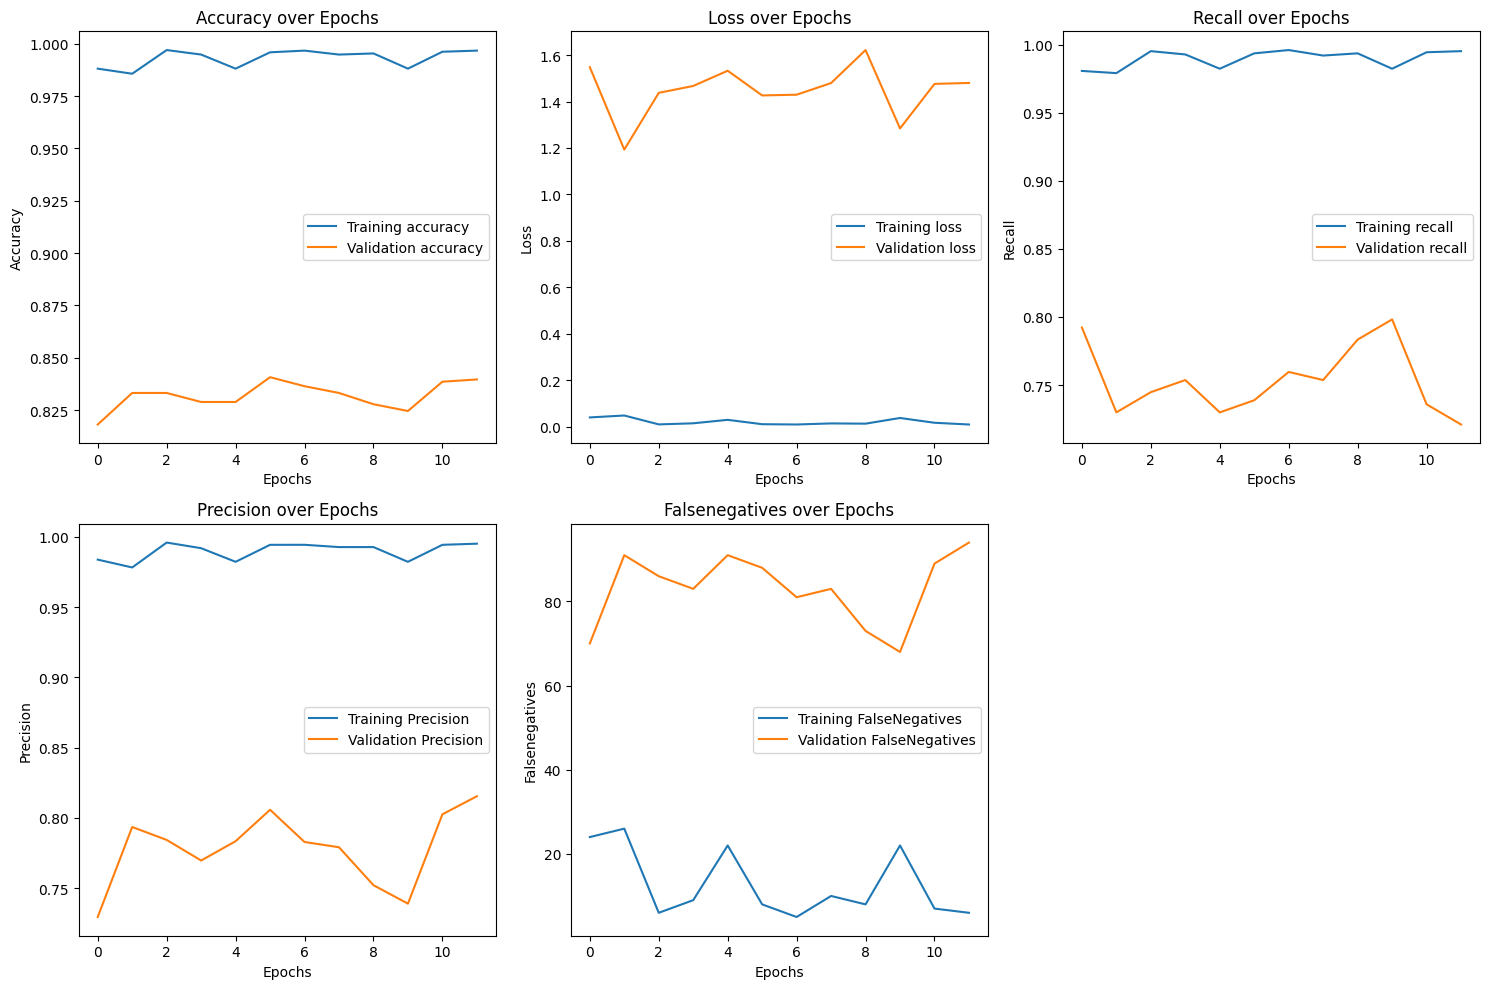

In [191]:
history_C = cnn_model.fit([train_elmo_embed_np, X_train_num], y_train,
                   epochs = 12,
                   batch_size = 16,
                   validation_split = 0.2)
plot_all_metrics(history_C)

Epoch 1/12
464/464 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step - FalseNegatives: 14.1226 - Precision: 0.9854 - accuracy: 0.9891 - loss: 0.0398 - recall: 0.9820 - val_FalseNegatives: 97.0000 - val_Precision: 0.8000 - val_accuracy: 0.8310 - val_loss: 1.1705 - val_recall: 0.7122
Epoch 2/12
464/464 ━━━━━━━━━━━━━━━━━━━━ 0s 968us/step - FalseNegatives: 8.9355 - Precision: 0.9911 - accuracy: 0.9931 - loss: 0.0186 - recall: 0.9885 - val_FalseNegatives: 95.0000 - val_Precision: 0.8094 - val_accuracy: 0.8364 - val_loss: 1.3393 - val_recall: 0.7181
Epoch 3/12
464/464 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step - FalseNegatives: 11.0645 - Precision: 0.9886 - accuracy: 0.9899 - loss: 0.0252 - recall: 0.9814 - val_FalseNegatives: 105.0000 - val_Precision: 0.8375 - val_accuracy: 0.8385 - val_loss: 1.5903 - val_recall: 0.6884
Epoch 4/12
464/464 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step - FalseNegatives: 8.9828 - Precision: 0.9907 - accuracy: 0.9904 - loss: 0.0383 - recall: 0.9808 - val_FalseNegatives: 83.0000 - val_Precision:

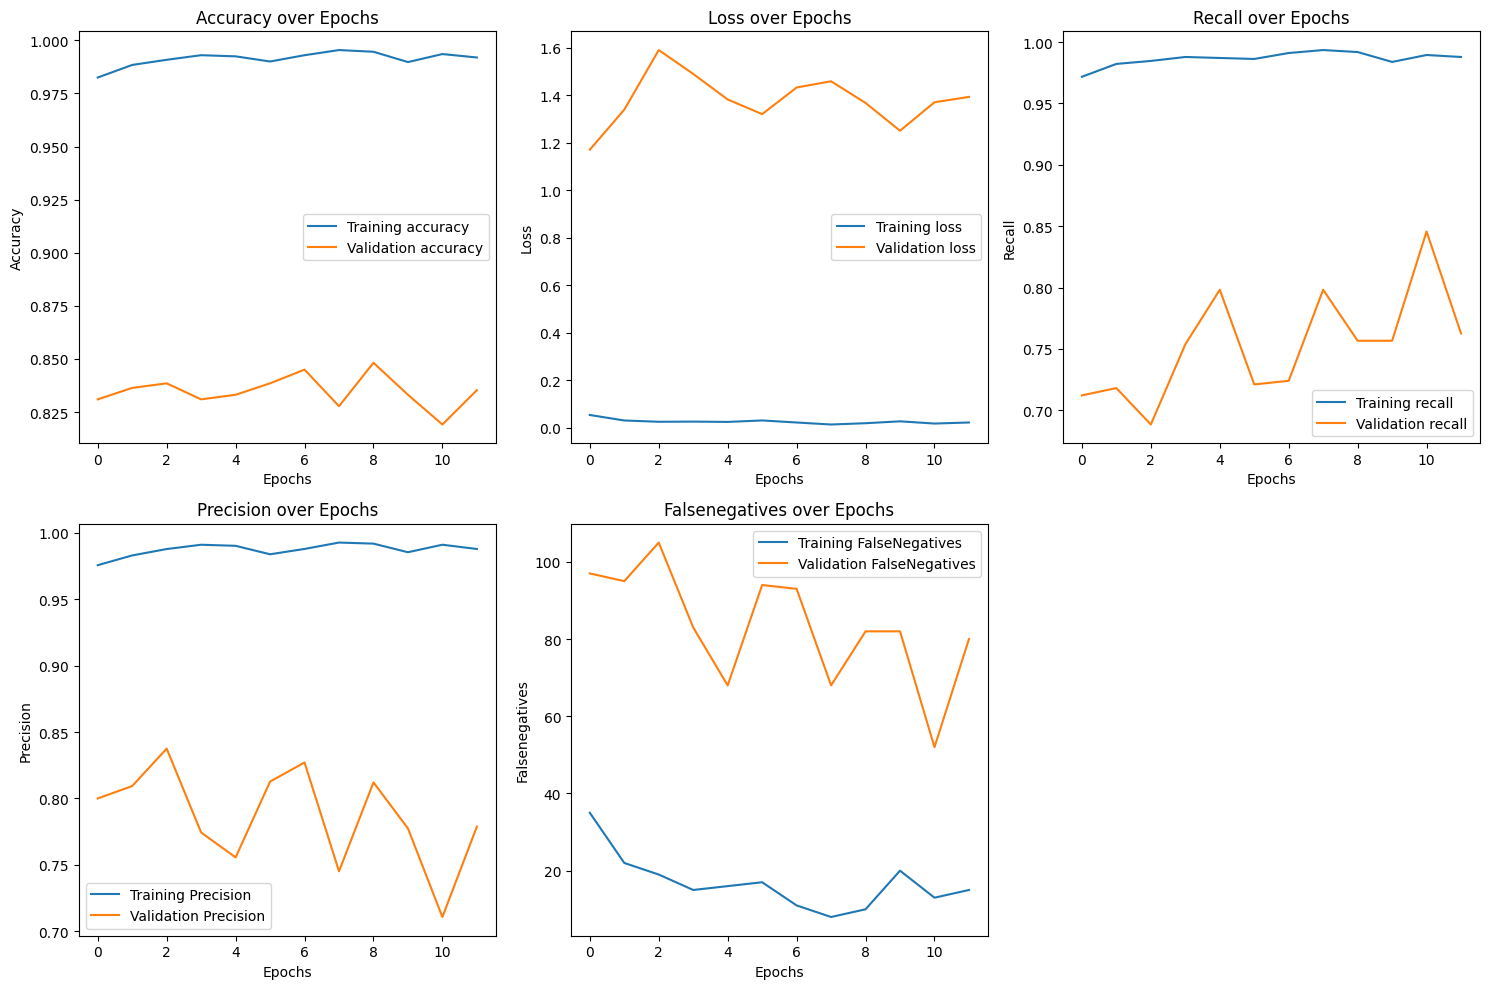

In [192]:
history_C = cnn_model.fit([train_elmo_embed_np, X_train_num], y_train,
                   epochs = 12,
                   batch_size = 8,
                   validation_split = 0.2)
plot_all_metrics(history_C)

### History for dropout 30% and 50 for combined layer LR= 0.0001

Epoch 1/12
116/116 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - FalseNegatives: 524.0427 - Precision: 0.3963 - accuracy: 0.6172 - loss: 0.6423 - recall: 0.2014 - val_FalseNegatives: 180.0000 - val_Precision: 0.7696 - val_accuracy: 0.7557 - val_loss: 0.5105 - val_recall: 0.4659
Epoch 2/12
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - FalseNegatives: 312.4530 - Precision: 0.7096 - accuracy: 0.7596 - loss: 0.4963 - recall: 0.4873 - val_FalseNegatives: 125.0000 - val_Precision: 0.7709 - val_accuracy: 0.7976 - val_loss: 0.4511 - val_recall: 0.6291
Epoch 3/12
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - FalseNegatives: 236.0769 - Precision: 0.7405 - accuracy: 0.8007 - loss: 0.4380 - recall: 0.6297 - val_FalseNegatives: 114.0000 - val_Precision: 0.7770 - val_accuracy: 0.8084 - val_loss: 0.4284 - val_recall: 0.6617
Epoch 4/12
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - FalseNegatives: 213.4530 - Precision: 0.7399 - accuracy: 0.8090 - loss: 0.4207 - recall: 0.6679 - val_FalseNegatives: 107.0000 - val_Precision

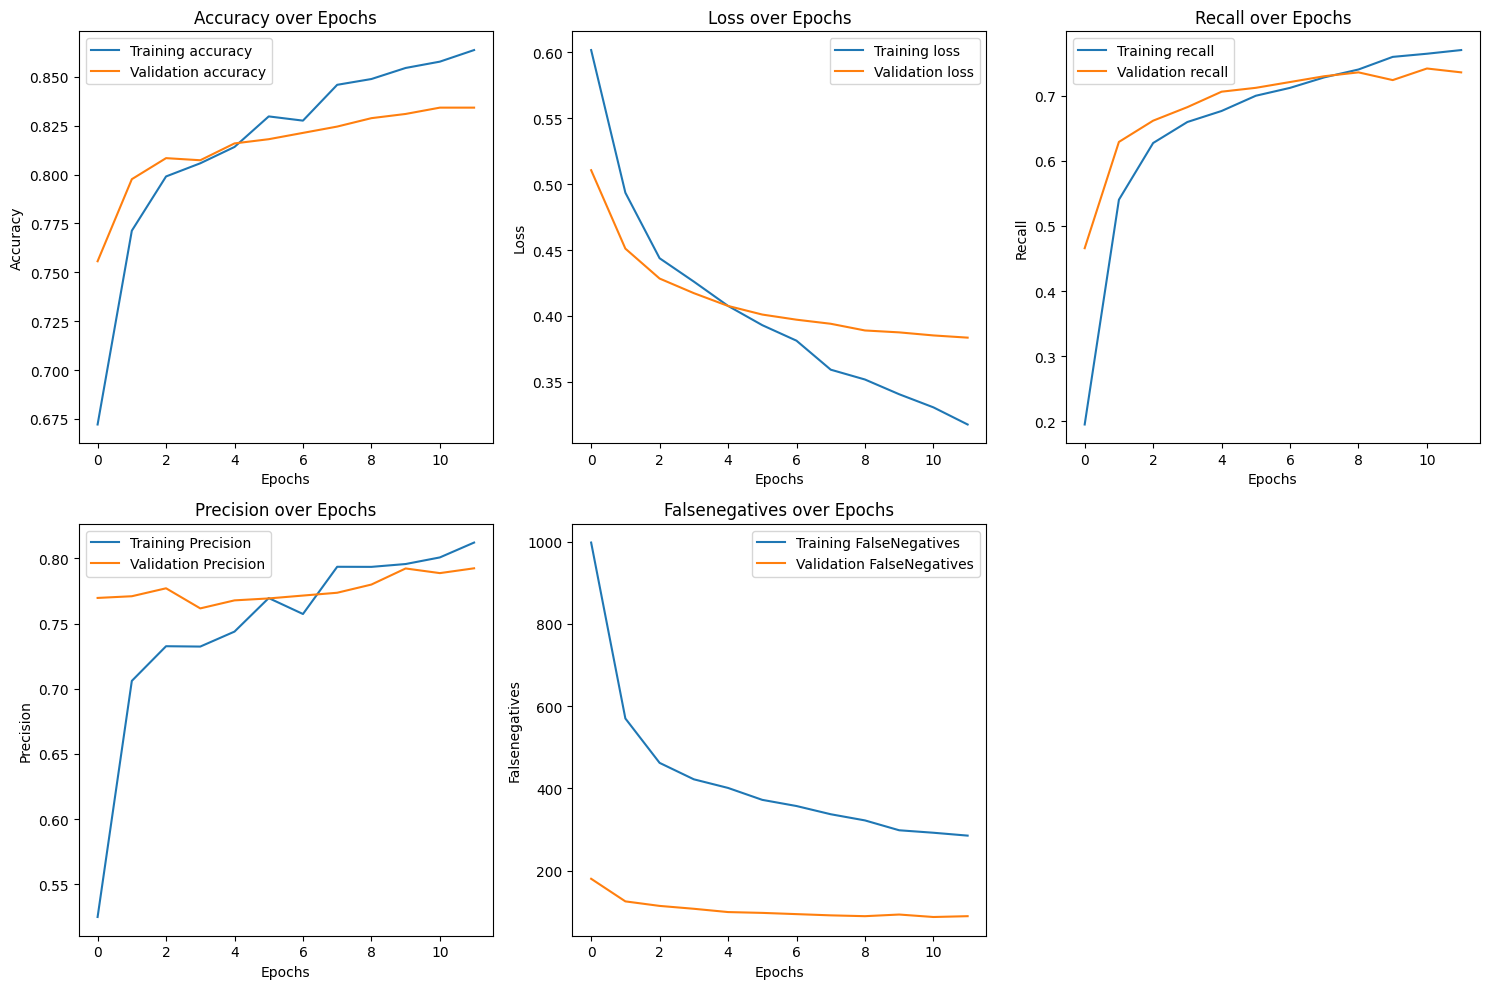

In [197]:
history_D = cnn_model.fit([train_elmo_embed_np, X_train_num], y_train,
                   epochs = 12,
                   batch_size = 32,
                   validation_split = 0.2)
plot_all_metrics(history_D)

Epoch 1/12
116/116 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - FalseNegatives: 100.7179 - Precision: 0.8708 - accuracy: 0.9071 - loss: 0.2328 - recall: 0.8505 - val_FalseNegatives: 90.0000 - val_Precision: 0.8072 - val_accuracy: 0.8396 - val_loss: 0.3918 - val_recall: 0.7329
Epoch 2/12
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - FalseNegatives: 96.9487 - Precision: 0.8768 - accuracy: 0.9100 - loss: 0.2188 - recall: 0.8526 - val_FalseNegatives: 89.0000 - val_Precision: 0.8000 - val_accuracy: 0.8375 - val_loss: 0.3939 - val_recall: 0.7359
Epoch 3/12
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - FalseNegatives: 88.0940 - Precision: 0.8922 - accuracy: 0.9199 - loss: 0.2107 - recall: 0.8668 - val_FalseNegatives: 89.0000 - val_Precision: 0.8026 - val_accuracy: 0.8385 - val_loss: 0.3938 - val_recall: 0.7359
Epoch 4/12
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - FalseNegatives: 80.6410 - Precision: 0.8788 - accuracy: 0.9189 - loss: 0.2074 - recall: 0.8809 - val_FalseNegatives: 89.0000 - val_Precision: 0.797

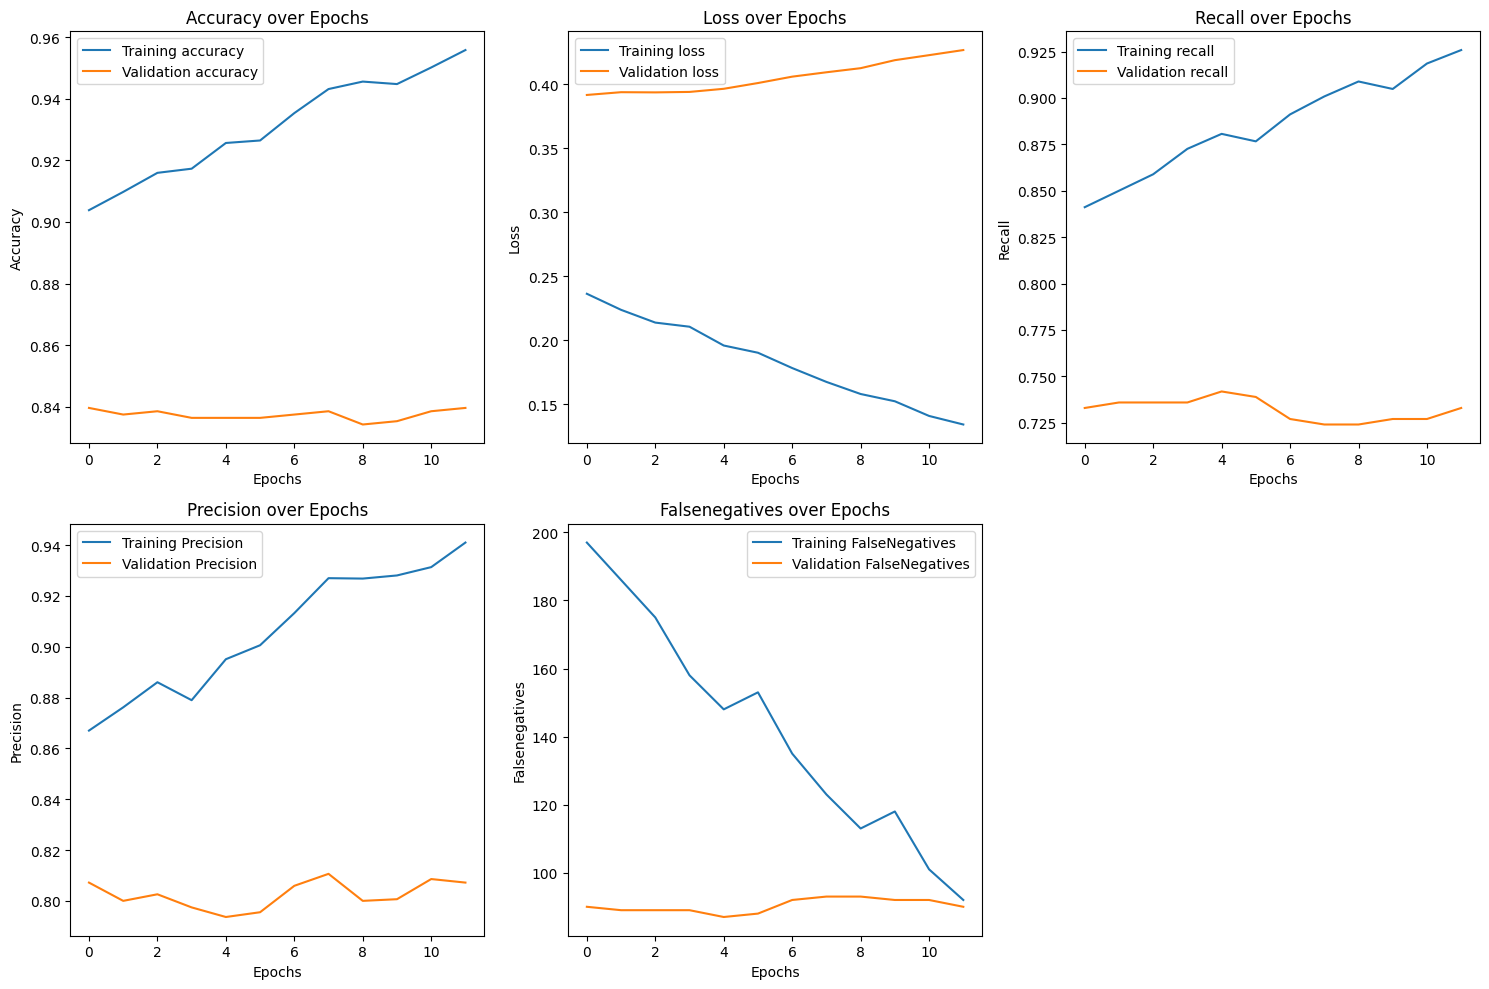

In [165]:
history_B = cnn_model.fit([train_elmo_embed_np, X_train_num], y_train,
                   epochs = 12,
                   batch_size = 32,
                   validation_split = 0.2)
plot_all_metrics(history_B)

Epoch 1/12
232/232 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - FalseNegatives: 49.5880 - Precision: 0.9402 - accuracy: 0.9549 - loss: 0.1288 - recall: 0.9251 - val_FalseNegatives: 91.0000 - val_Precision: 0.8146 - val_accuracy: 0.8418 - val_loss: 0.4431 - val_recall: 0.7300
Epoch 2/12
232/232 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - FalseNegatives: 37.8455 - Precision: 0.9495 - accuracy: 0.9643 - loss: 0.1202 - recall: 0.9442 - val_FalseNegatives: 80.0000 - val_Precision: 0.7908 - val_accuracy: 0.8407 - val_loss: 0.4469 - val_recall: 0.7626
Epoch 3/12
232/232 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - FalseNegatives: 30.4034 - Precision: 0.9586 - accuracy: 0.9704 - loss: 0.0993 - recall: 0.9533 - val_FalseNegatives: 94.0000 - val_Precision: 0.8020 - val_accuracy: 0.8342 - val_loss: 0.4671 - val_recall: 0.7211
Epoch 4/12
232/232 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - FalseNegatives: 26.6137 - Precision: 0.9524 - accuracy: 0.9704 - loss: 0.0888 - recall: 0.9601 - val_FalseNegatives: 92.0000 - val_Precision: 0.8086

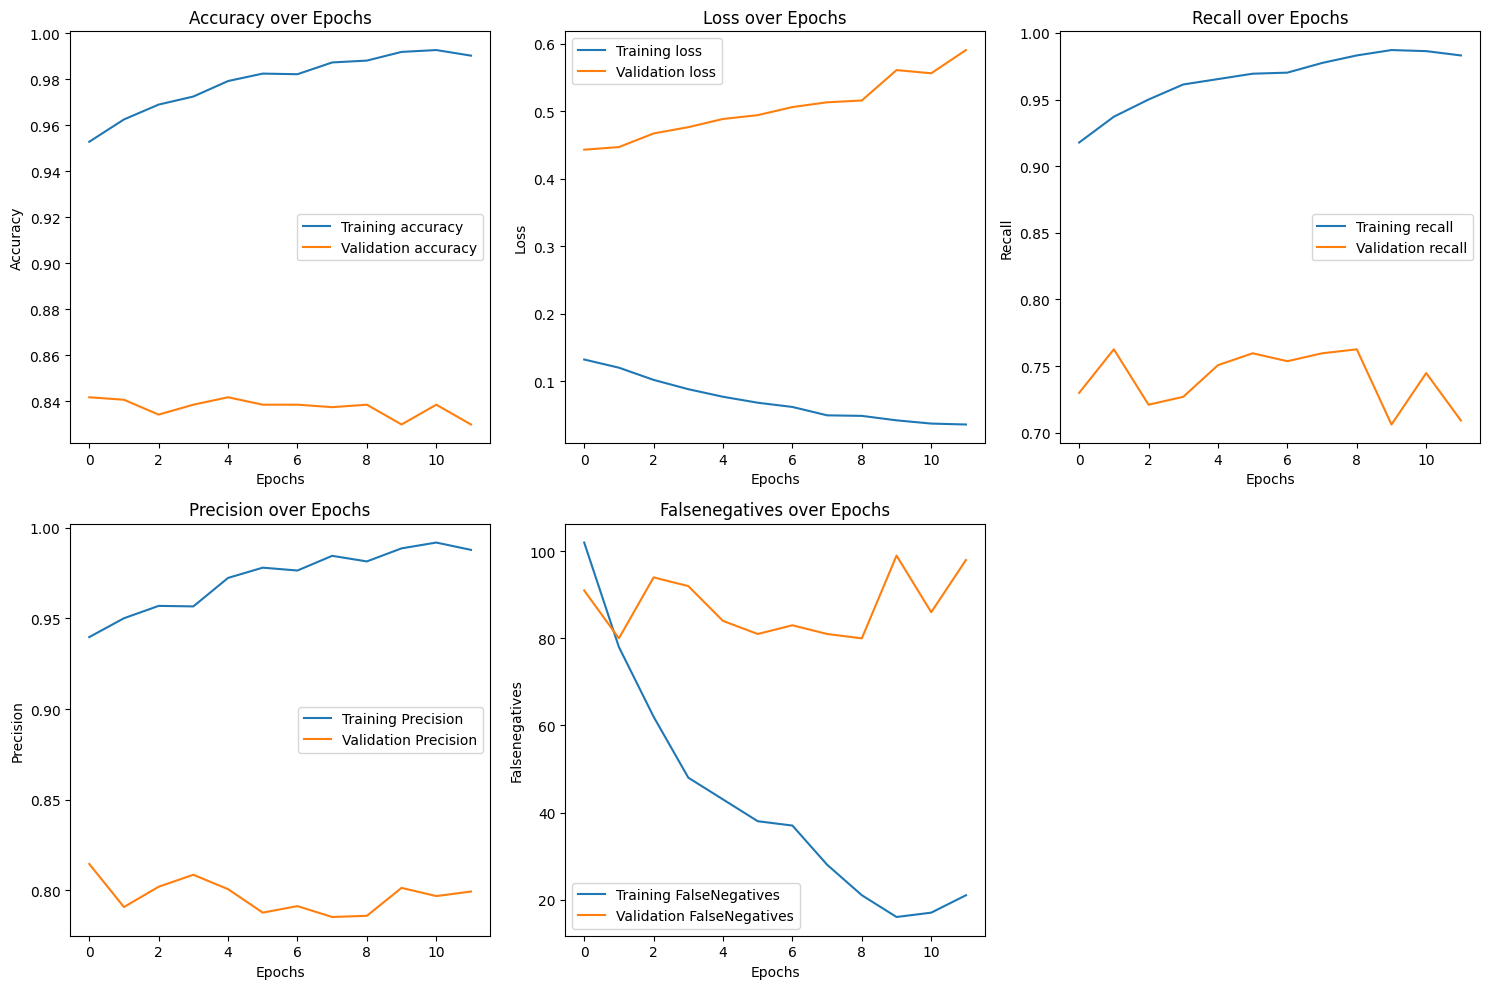

In [166]:
history_B = cnn_model.fit([train_elmo_embed_np, X_train_num], y_train,
                   epochs = 12,
                   batch_size = 16,
                   validation_split = 0.2)
plot_all_metrics(history_B)

### History A

In [81]:
history_A = cnn_model.fit([train_elmo_embed_np, X_train_num], y_train,
                   epochs = 10,
                   batch_size = 16,
                   validation_split = 0.30,
                   callbacks=[ClearMemory()])

Epoch 1/10
203/203 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - FalseNegatives: 278.0931 - Precision: 0.6092 - accuracy: 0.7371 - loss: 0.5403 - recall: 0.3991 - val_FalseNegatives: 169.0000 - val_Precision: 0.7528 - val_accuracy: 0.7990 - val_loss: 0.4372 - val_recall: 0.6667
Epoch 2/10
203/203 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - FalseNegatives: 183.4804 - Precision: 0.7233 - accuracy: 0.8088 - loss: 0.4075 - recall: 0.6504 - val_FalseNegatives: 136.0000 - val_Precision: 0.7480 - val_accuracy: 0.8126 - val_loss: 0.4168 - val_recall: 0.7318
Epoch 3/10
203/203 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - FalseNegatives: 151.9314 - Precision: 0.7312 - accuracy: 0.8237 - loss: 0.3996 - recall: 0.7109 - val_FalseNegatives: 119.0000 - val_Precision: 0.7490 - val_accuracy: 0.8212 - val_loss: 0.3995 - val_recall: 0.7653
Epoch 4/10
203/203 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - FalseNegatives: 141.3676 - Precision: 0.7660 - accuracy: 0.8435 - loss: 0.3563 - recall: 0.7354 - val_FalseNegatives: 121.0000 - val_Precision

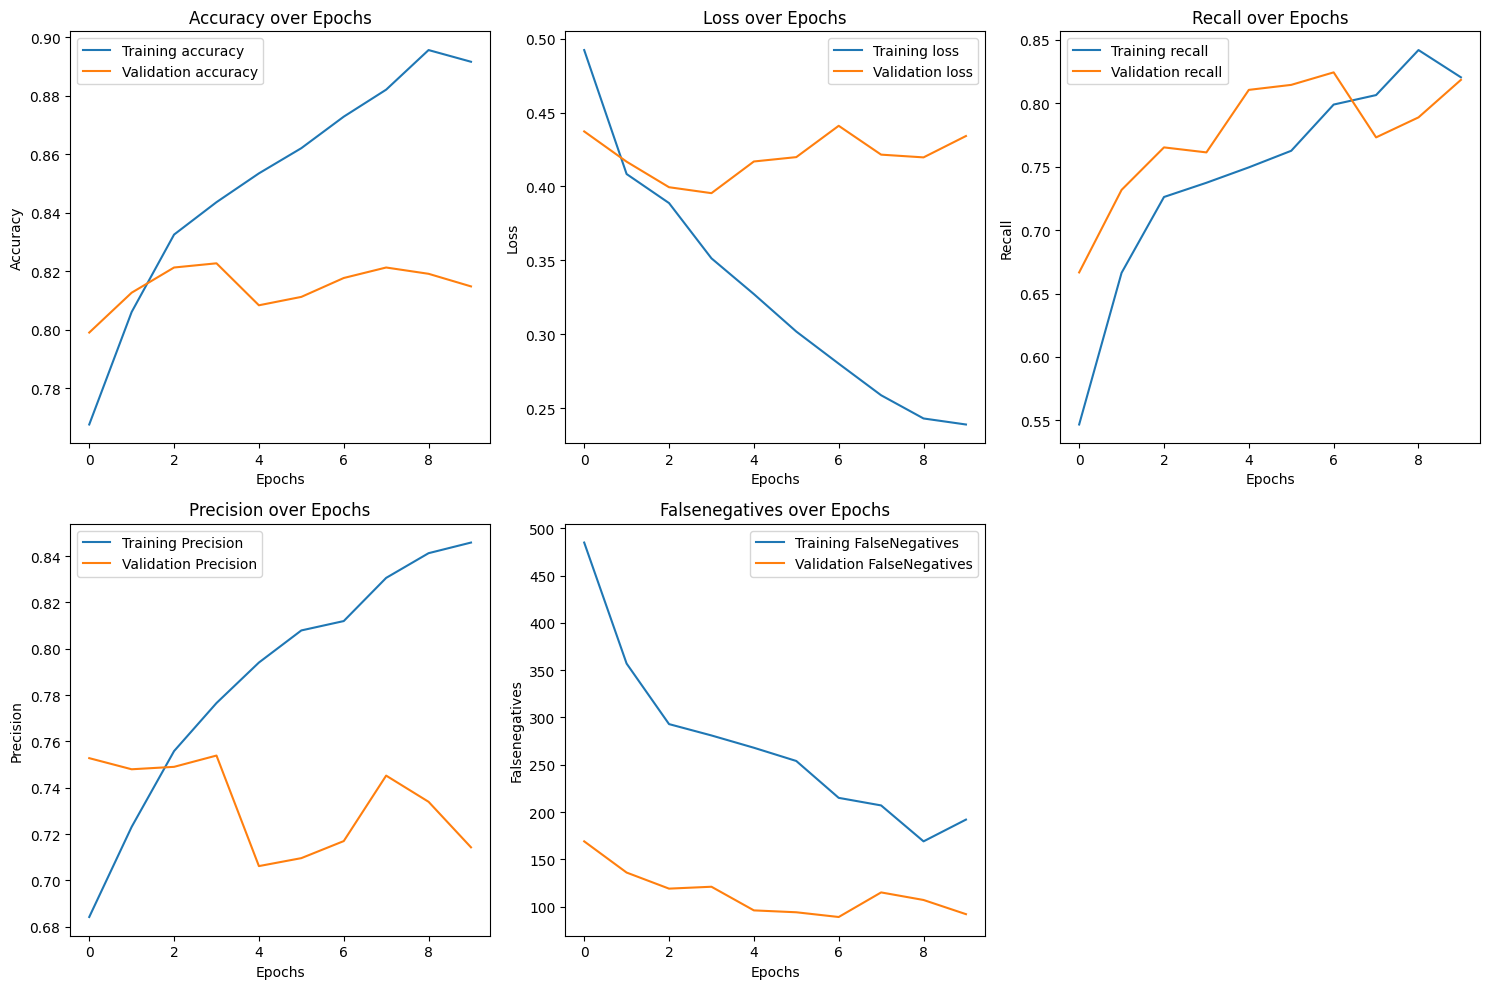

In [110]:
plot_all_metrics(history_A)

Epoch 1/7
203/203 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - FalseNegatives: 9.8039 - Precision: 0.9837 - accuracy: 0.9887 - loss: 0.0392 - recall: 0.9809 - val_FalseNegatives: 94.0000 - val_Precision: 0.8825 - val_accuracy: 0.8930 - val_loss: 0.4531 - val_recall: 0.8146
Epoch 2/7
203/203 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - FalseNegatives: 8.5294 - Precision: 0.9850 - accuracy: 0.9900 - loss: 0.0334 - recall: 0.9842 - val_FalseNegatives: 84.0000 - val_Precision: 0.8615 - val_accuracy: 0.8909 - val_loss: 0.4510 - val_recall: 0.8343
Epoch 3/7
203/203 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - FalseNegatives: 6.7892 - Precision: 0.9933 - accuracy: 0.9943 - loss: 0.0261 - recall: 0.9890 - val_FalseNegatives: 75.0000 - val_Precision: 0.8421 - val_accuracy: 0.8880 - val_loss: 0.4547 - val_recall: 0.8521
Epoch 4/7
203/203 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - FalseNegatives: 9.4804 - Precision: 0.9846 - accuracy: 0.9895 - loss: 0.0422 - recall: 0.9817 - val_FalseNegatives: 89.0000 - val_Precision: 0.8727 - val_a

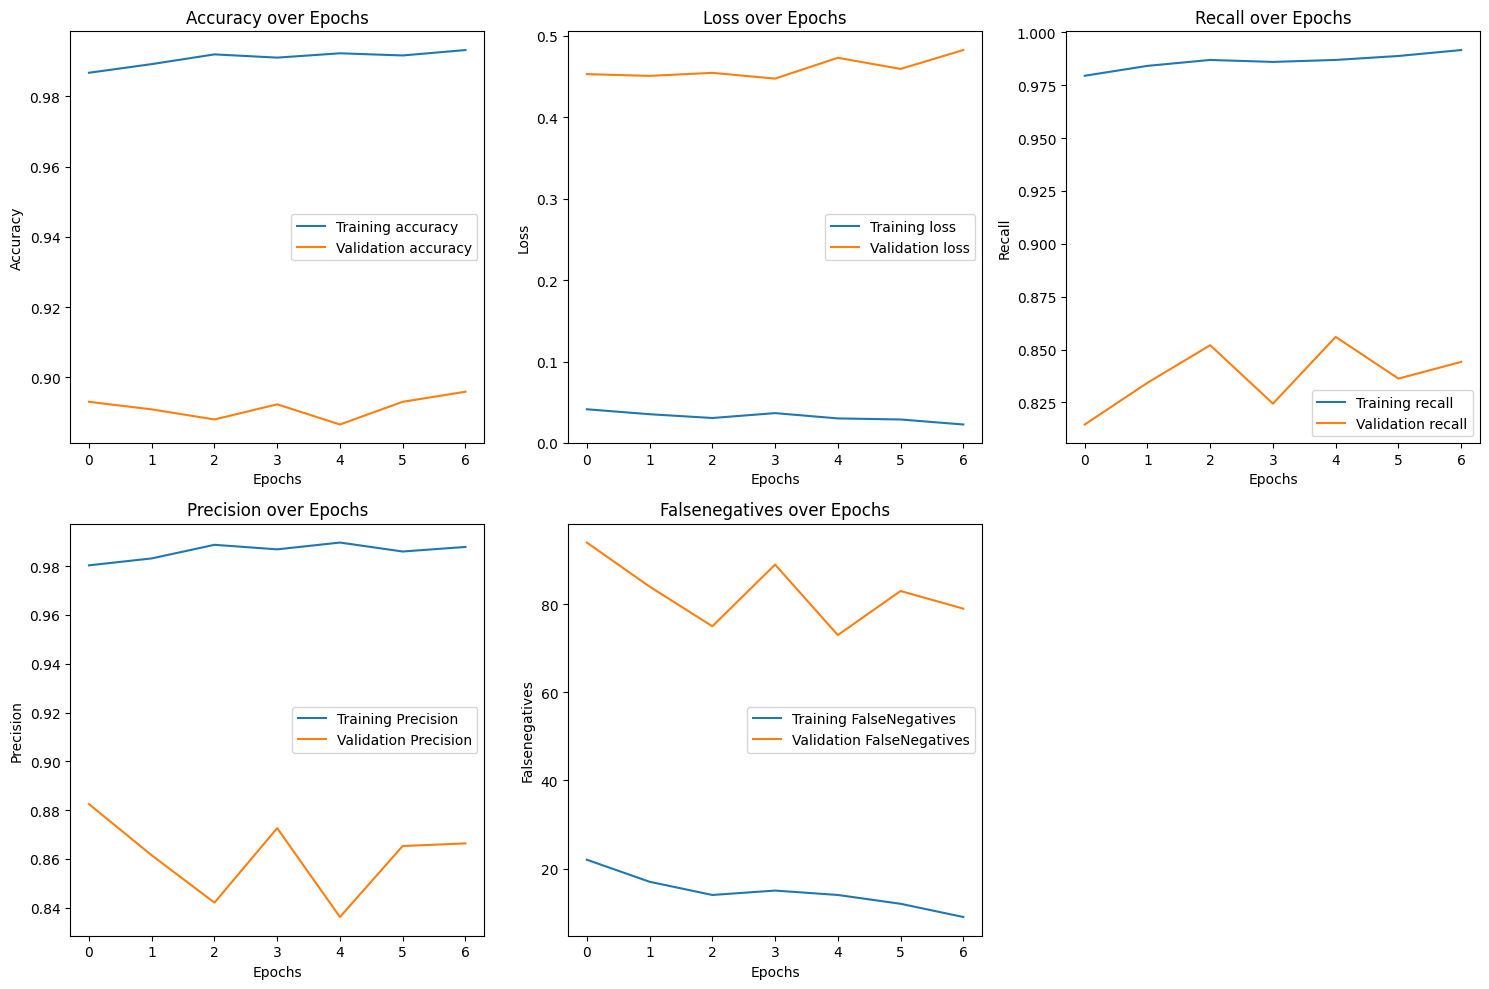

In [158]:
history_A = cnn_model.fit([train_elmo_embed_np, X_train_num], y_train,
                   epochs = 7,
                   batch_size = 16,
                   validation_split = 0.30,
                   callbacks=[ClearMemory()])
plot_all_metrics(history_A)

Epoch 1/12
232/232 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - FalseNegatives: 9.2833 - Precision: 0.9868 - accuracy: 0.9914 - loss: 0.0271 - recall: 0.9876 - val_FalseNegatives: 84.0000 - val_Precision: 0.8032 - val_accuracy: 0.8428 - val_loss: 0.7079 - val_recall: 0.7507
Epoch 2/12
232/232 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - FalseNegatives: 7.7210 - Precision: 0.9891 - accuracy: 0.9917 - loss: 0.0272 - recall: 0.9862 - val_FalseNegatives: 95.0000 - val_Precision: 0.8203 - val_accuracy: 0.8407 - val_loss: 0.7373 - val_recall: 0.7181
Epoch 3/12
232/232 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - FalseNegatives: 5.2747 - Precision: 0.9938 - accuracy: 0.9952 - loss: 0.0223 - recall: 0.9920 - val_FalseNegatives: 81.0000 - val_Precision: 0.8025 - val_accuracy: 0.8450 - val_loss: 0.7312 - val_recall: 0.7596
Epoch 4/12
232/232 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - FalseNegatives: 4.0644 - Precision: 0.9969 - accuracy: 0.9973 - loss: 0.0186 - recall: 0.9950 - val_FalseNegatives: 91.0000 - val_Precision: 0.8146 - v

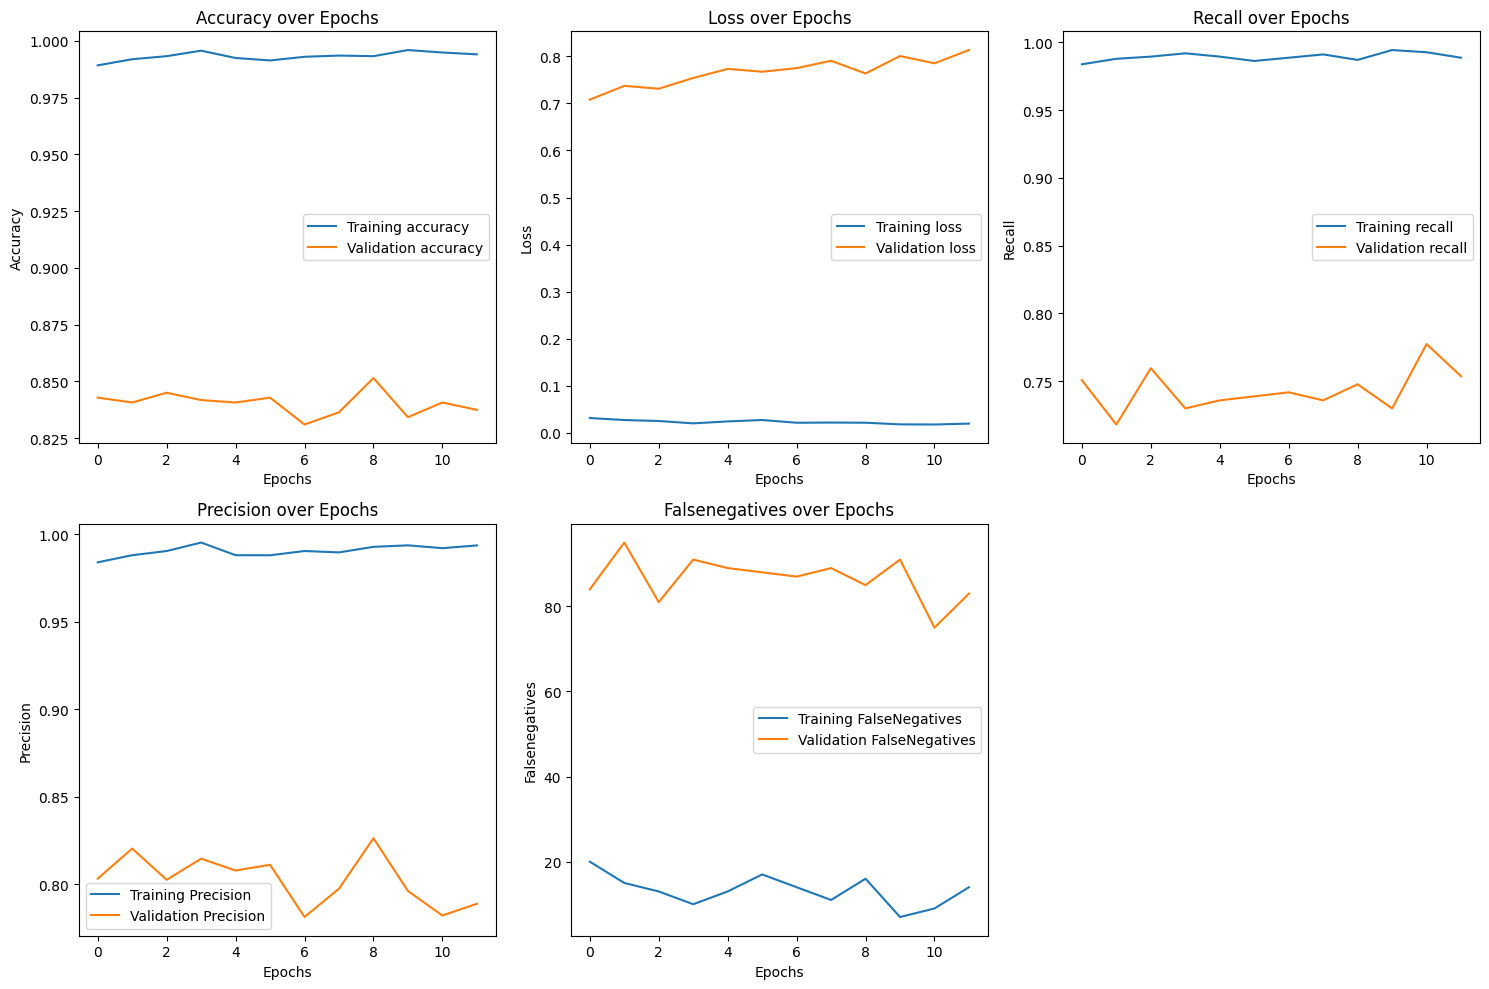

In [159]:
history_A = cnn_model.fit([train_elmo_embed_np, X_train_num], y_train,
                   epochs = 12,
                   batch_size = 16,
                   validation_split = 0.2,
                   callbacks=[ClearMemory()])
plot_all_metrics(history_A)

Epoch 1/12
116/116 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - FalseNegatives: 15.4017 - Precision: 0.9749 - accuracy: 0.9838 - loss: 0.0534 - recall: 0.9772 - val_FalseNegatives: 85.0000 - val_Precision: 0.8025 - val_accuracy: 0.8418 - val_loss: 0.6079 - val_recall: 0.7478
Epoch 2/12
116/116 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - FalseNegatives: 14.8632 - Precision: 0.9867 - accuracy: 0.9875 - loss: 0.0439 - recall: 0.9761 - val_FalseNegatives: 86.0000 - val_Precision: 0.7994 - val_accuracy: 0.8396 - val_loss: 0.6088 - val_recall: 0.7448
Epoch 3/12
116/116 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - FalseNegatives: 16.2308 - Precision: 0.9869 - accuracy: 0.9871 - loss: 0.0422 - recall: 0.9748 - val_FalseNegatives: 81.0000 - val_Precision: 0.7950 - val_accuracy: 0.8418 - val_loss: 0.6142 - val_recall: 0.7596
Epoch 4/12
116/116 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - FalseNegatives: 8.3675 - Precision: 0.9933 - accuracy: 0.9933 - loss: 0.0365 - recall: 0.9867 - val_FalseNegatives: 86.0000 - val_Precision: 0.7994 

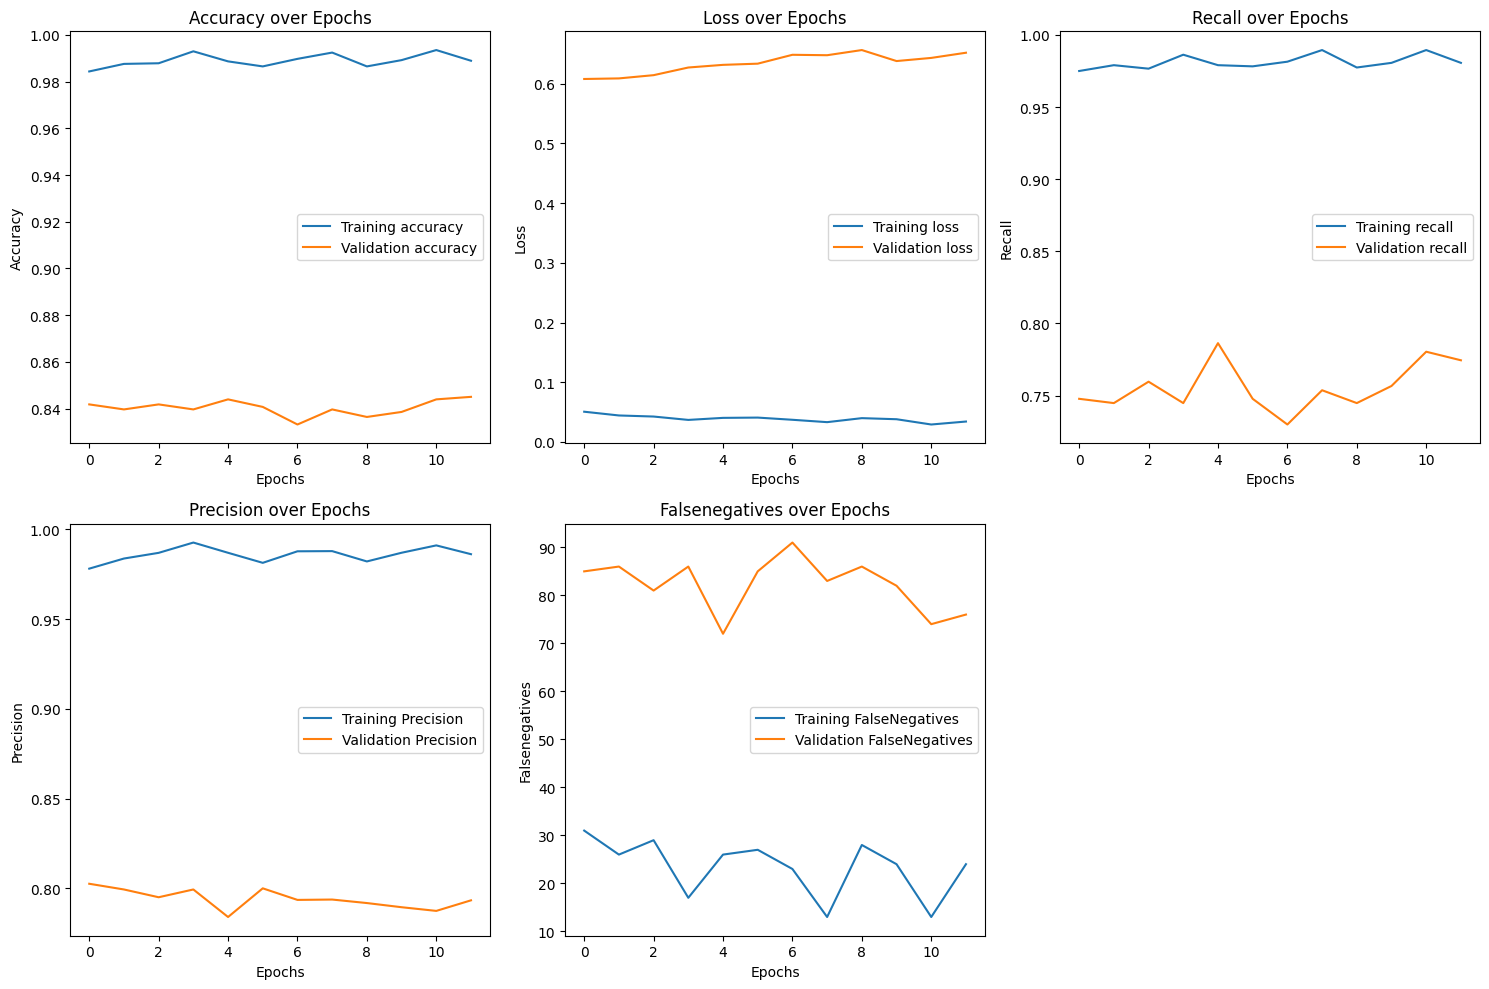

In [157]:
history_A = cnn_model.fit([train_elmo_embed_np, X_train_num], y_train,
                   epochs = 12,
                   batch_size = 32,
                   validation_split = 0.2,
                   callbacks=[ClearMemory()])
plot_all_metrics(history_A)

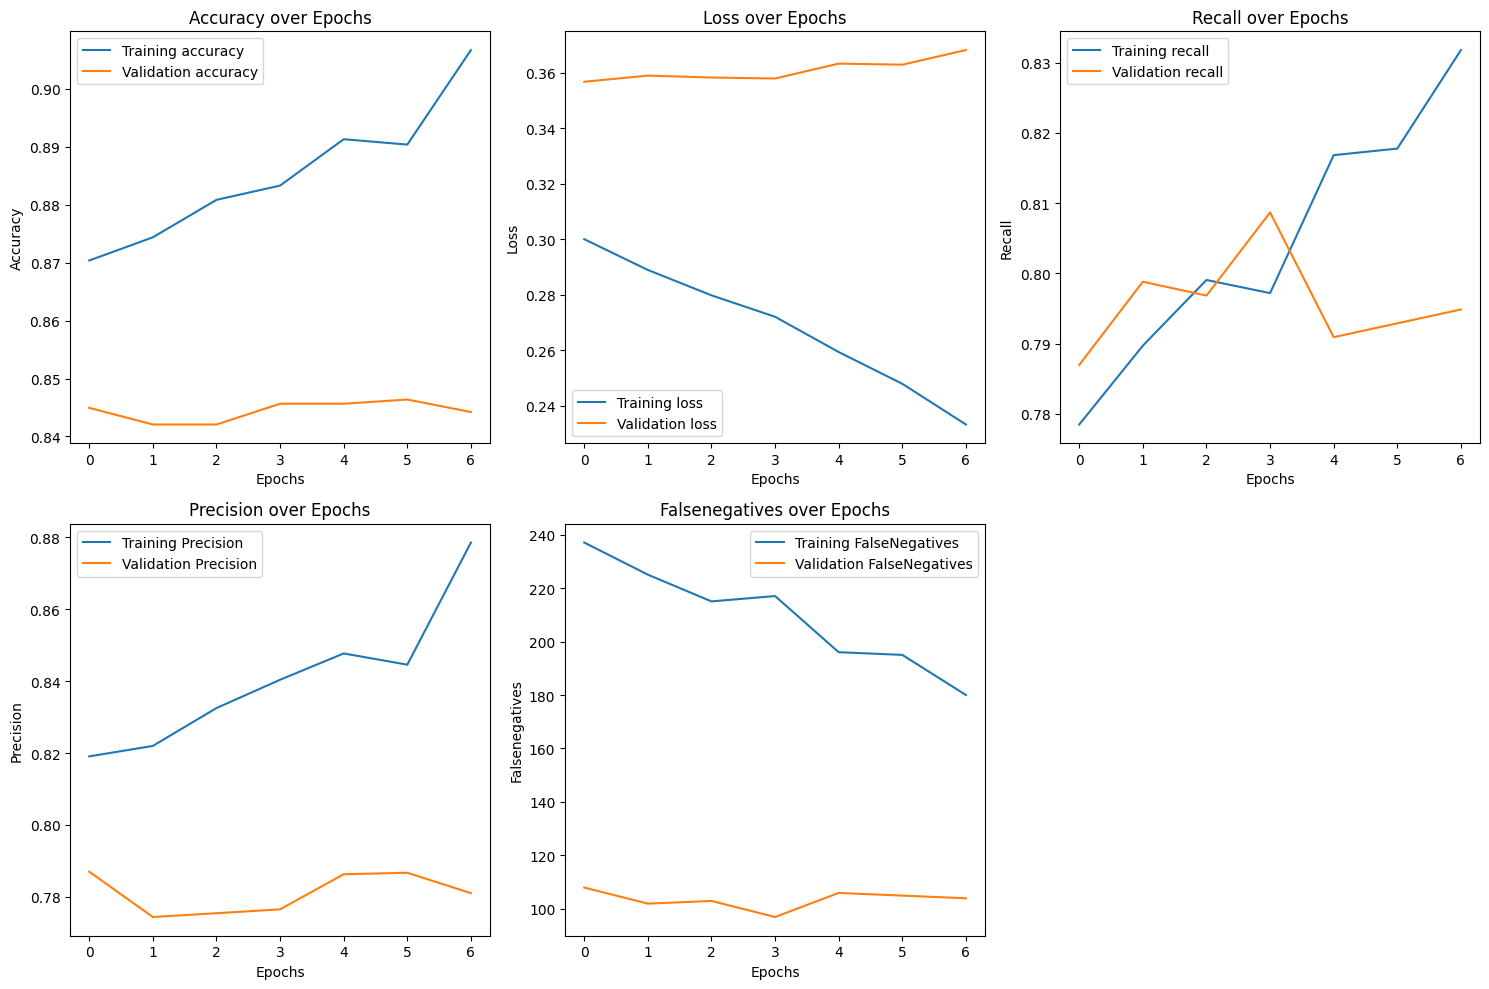

### History B

In [92]:
cnn_model = create_cnn_model(input_shape_text, input_shape_num)
history_B = cnn_model.fit([train_elmo_embed_np, X_train_num], y_train,
                   epochs = 12,
                   batch_size = 32,
                   validation_split = 0.3)
                   # callbacks=[ClearMemory()])

Epoch 1/12
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - FalseNegatives: 308.1942 - Precision: 0.6058 - accuracy: 0.7296 - loss: 0.5502 - recall: 0.3451 - val_FalseNegatives: 145.0000 - val_Precision: 0.7211 - val_accuracy: 0.7954 - val_loss: 0.4350 - val_recall: 0.7140
Epoch 2/12
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - FalseNegatives: 187.7767 - Precision: 0.7175 - accuracy: 0.8058 - loss: 0.4284 - recall: 0.6529 - val_FalseNegatives: 159.0000 - val_Precision: 0.7648 - val_accuracy: 0.8090 - val_loss: 0.4208 - val_recall: 0.6864
Epoch 3/12
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - FalseNegatives: 159.7281 - Precision: 0.7274 - accuracy: 0.8191 - loss: 0.3900 - recall: 0.6964 - val_FalseNegatives: 123.0000 - val_Precision: 0.7273 - val_accuracy: 0.8083 - val_loss: 0.4043 - val_recall: 0.7574
Epoch 4/12
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - FalseNegatives: 153.2330 - Precision: 0.7426 - accuracy: 0.8294 - loss: 0.3659 - recall: 0.7190 - val_FalseNegatives: 121.0000 - val_Precision

In [148]:
cnn_model = create_cnn_model(input_shape_text, input_shape_num)
history_C = cnn_model.fit([train_elmo_embed_np, X_train_num], y_train,
                   epochs = 12,
                   batch_size = 16,
                   validation_split = 0.2)
                   # callbacks=[ClearMemory()])

Epoch 1/12
232/232 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - FalseNegatives: 486.5880 - Precision: 0.5082 - accuracy: 0.6619 - loss: 0.6157 - recall: 0.2088 - val_FalseNegatives: 140.0000 - val_Precision: 0.7725 - val_accuracy: 0.7869 - val_loss: 0.4841 - val_recall: 0.5846
Epoch 2/12
232/232 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - FalseNegatives: 280.1931 - Precision: 0.7143 - accuracy: 0.7725 - loss: 0.4805 - recall: 0.5430 - val_FalseNegatives: 114.0000 - val_Precision: 0.7716 - val_accuracy: 0.8062 - val_loss: 0.4379 - val_recall: 0.6617
Epoch 3/12
232/232 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - FalseNegatives: 232.6352 - Precision: 0.7452 - accuracy: 0.8041 - loss: 0.4349 - recall: 0.6360 - val_FalseNegatives: 105.0000 - val_Precision: 0.7682 - val_accuracy: 0.8116 - val_loss: 0.4242 - val_recall: 0.6884
Epoch 4/12
232/232 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - FalseNegatives: 208.2575 - Precision: 0.7581 - accuracy: 0.8169 - loss: 0.4147 - recall: 0.6708 - val_FalseNegatives: 97.0000 - val_Precision:

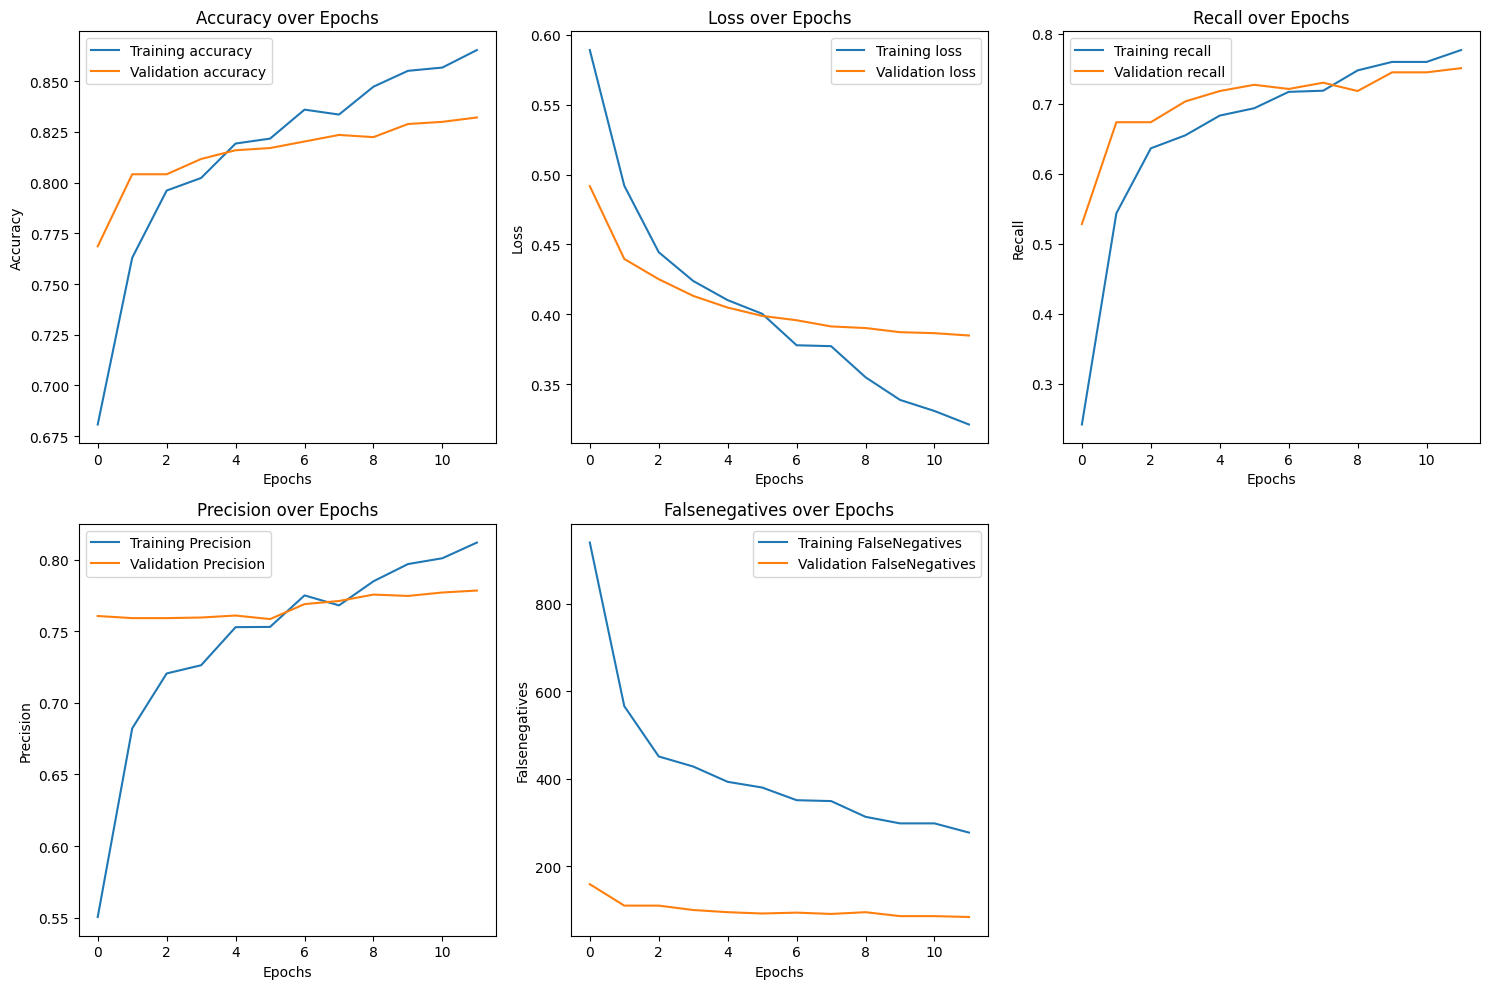

In [146]:
plot_all_metrics(history_C)

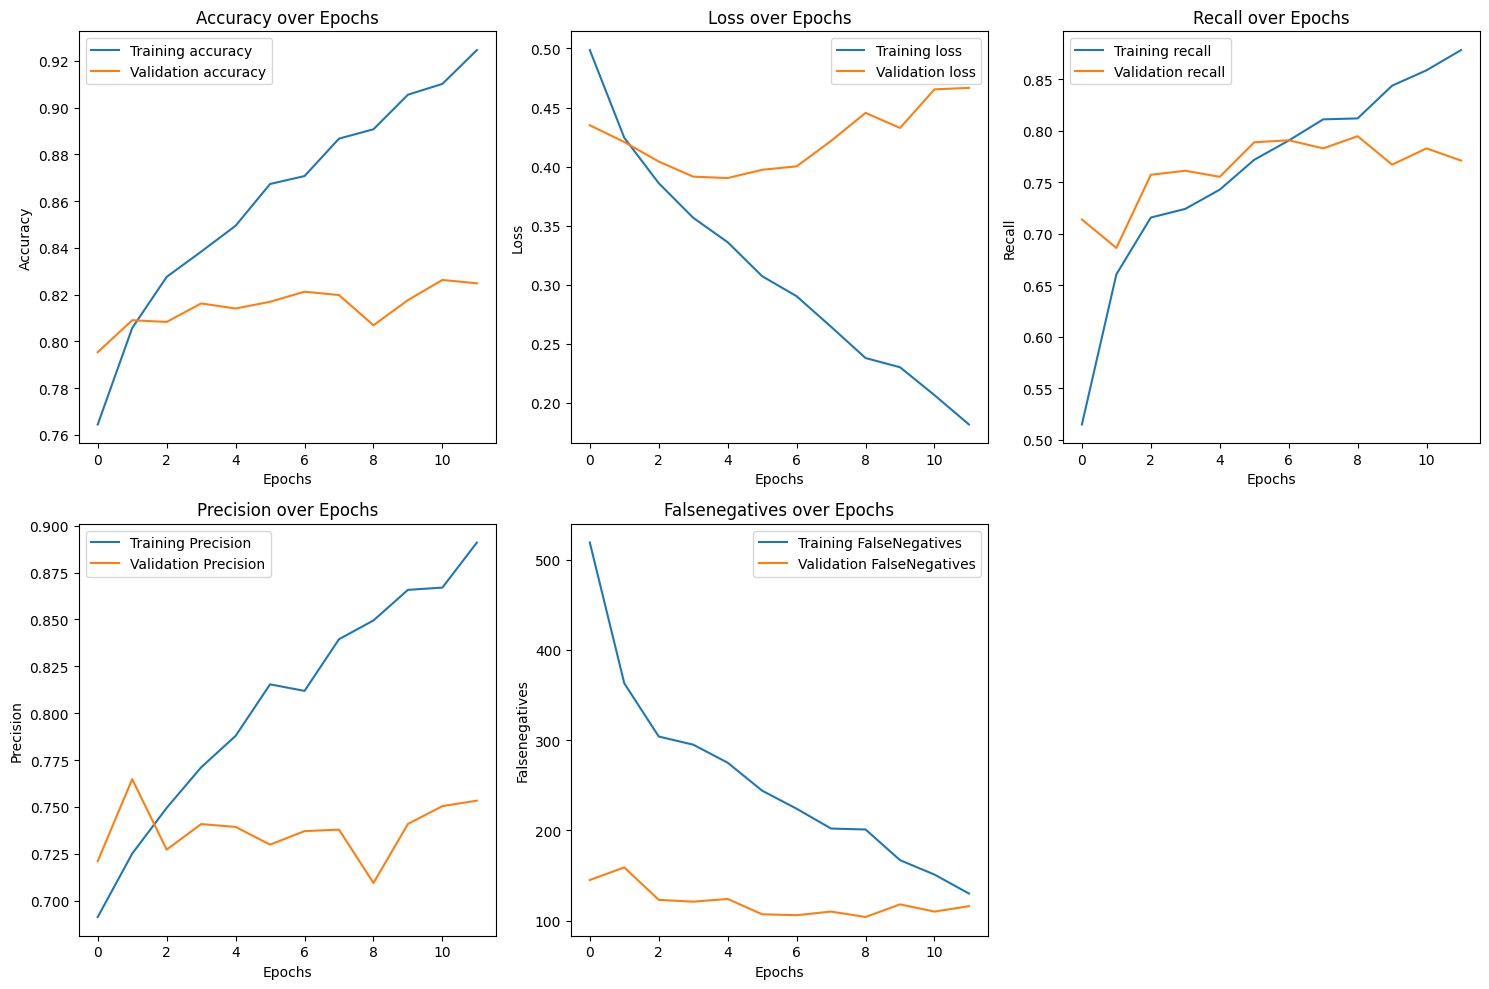

In [112]:
plot_all_metrics(history_B)

In [93]:
cnn_model = create_cnn_model(input_shape_text, input_shape_num)
history_C = cnn_model.fit([train_elmo_embed_np, X_train_num], y_train,
                   epochs = 50,
                   batch_size = 12,
                   validation_split = 0.2)

Epoch 1/50
310/310 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - FalseNegatives: 297.1254 - Precision: 0.6116 - accuracy: 0.7217 - loss: 0.5465 - recall: 0.4888 - val_FalseNegatives: 123.0000 - val_Precision: 0.7726 - val_accuracy: 0.7998 - val_loss: 0.4205 - val_recall: 0.6350
Epoch 2/50
310/310 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - FalseNegatives: 213.4534 - Precision: 0.7529 - accuracy: 0.8134 - loss: 0.4207 - recall: 0.6642 - val_FalseNegatives: 100.0000 - val_Precision: 0.7770 - val_accuracy: 0.8192 - val_loss: 0.4026 - val_recall: 0.7033
Epoch 3/50
310/310 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - FalseNegatives: 183.5563 - Precision: 0.7530 - accuracy: 0.8242 - loss: 0.3807 - recall: 0.7128 - val_FalseNegatives: 87.0000 - val_Precision: 0.7716 - val_accuracy: 0.8267 - val_loss: 0.3956 - val_recall: 0.7418
Epoch 4/50
310/310 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - FalseNegatives: 164.8199 - Precision: 0.7730 - accuracy: 0.8401 - loss: 0.3491 - recall: 0.7444 - val_FalseNegatives: 90.0000 - val_Precision: 

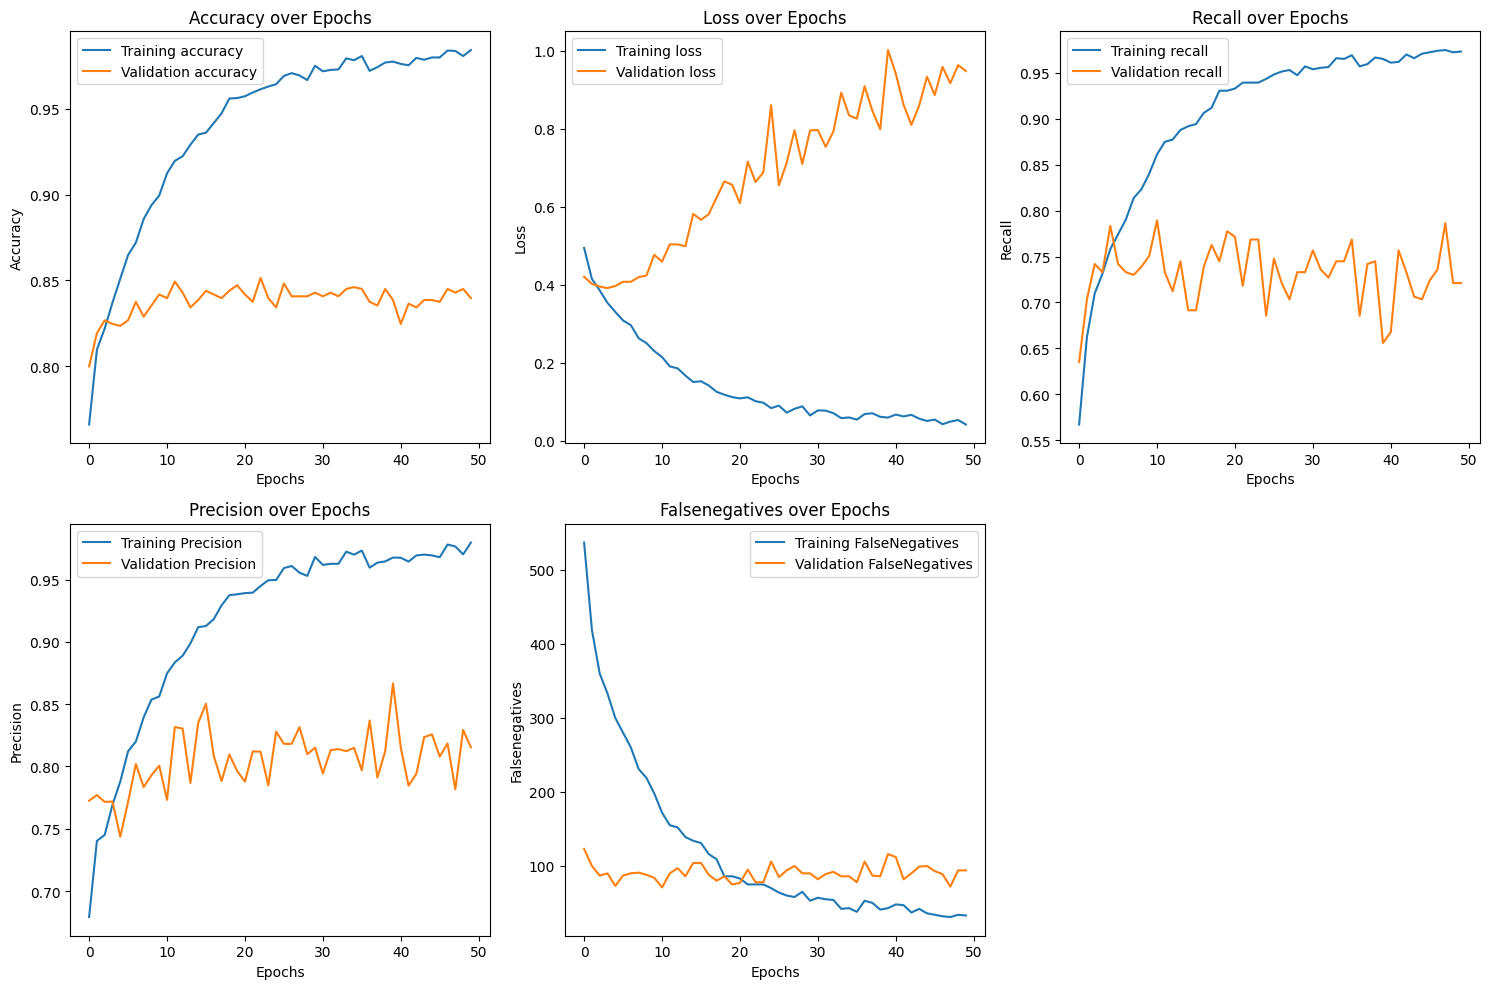

In [113]:
plot_all_metrics(history_C)

In [117]:
cnn_model = create_cnn_model(input_shape_text, input_shape_num)
history_D = cnn_model.fit([train_elmo_embed_np, X_train_num], y_train,
                   epochs = 12,
                   batch_size = 32,
                   validation_split = 0.3)

Epoch 1/12
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - FalseNegatives: 306.5437 - Precision: 0.5660 - accuracy: 0.7219 - loss: 0.5484 - recall: 0.3462 - val_FalseNegatives: 167.0000 - val_Precision: 0.7506 - val_accuracy: 0.7990 - val_loss: 0.4349 - val_recall: 0.6706
Epoch 2/12
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - FalseNegatives: 195.6699 - Precision: 0.6913 - accuracy: 0.7902 - loss: 0.4329 - recall: 0.6283 - val_FalseNegatives: 150.0000 - val_Precision: 0.7564 - val_accuracy: 0.8098 - val_loss: 0.4132 - val_recall: 0.7041
Epoch 3/12
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - FalseNegatives: 163.1456 - Precision: 0.7313 - accuracy: 0.8203 - loss: 0.3873 - recall: 0.6940 - val_FalseNegatives: 117.0000 - val_Precision: 0.7358 - val_accuracy: 0.8155 - val_loss: 0.3937 - val_recall: 0.7692
Epoch 4/12
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - FalseNegatives: 140.5922 - Precision: 0.7393 - accuracy: 0.8315 - loss: 0.3653 - recall: 0.7328 - val_FalseNegatives: 120.0000 - val_Precision

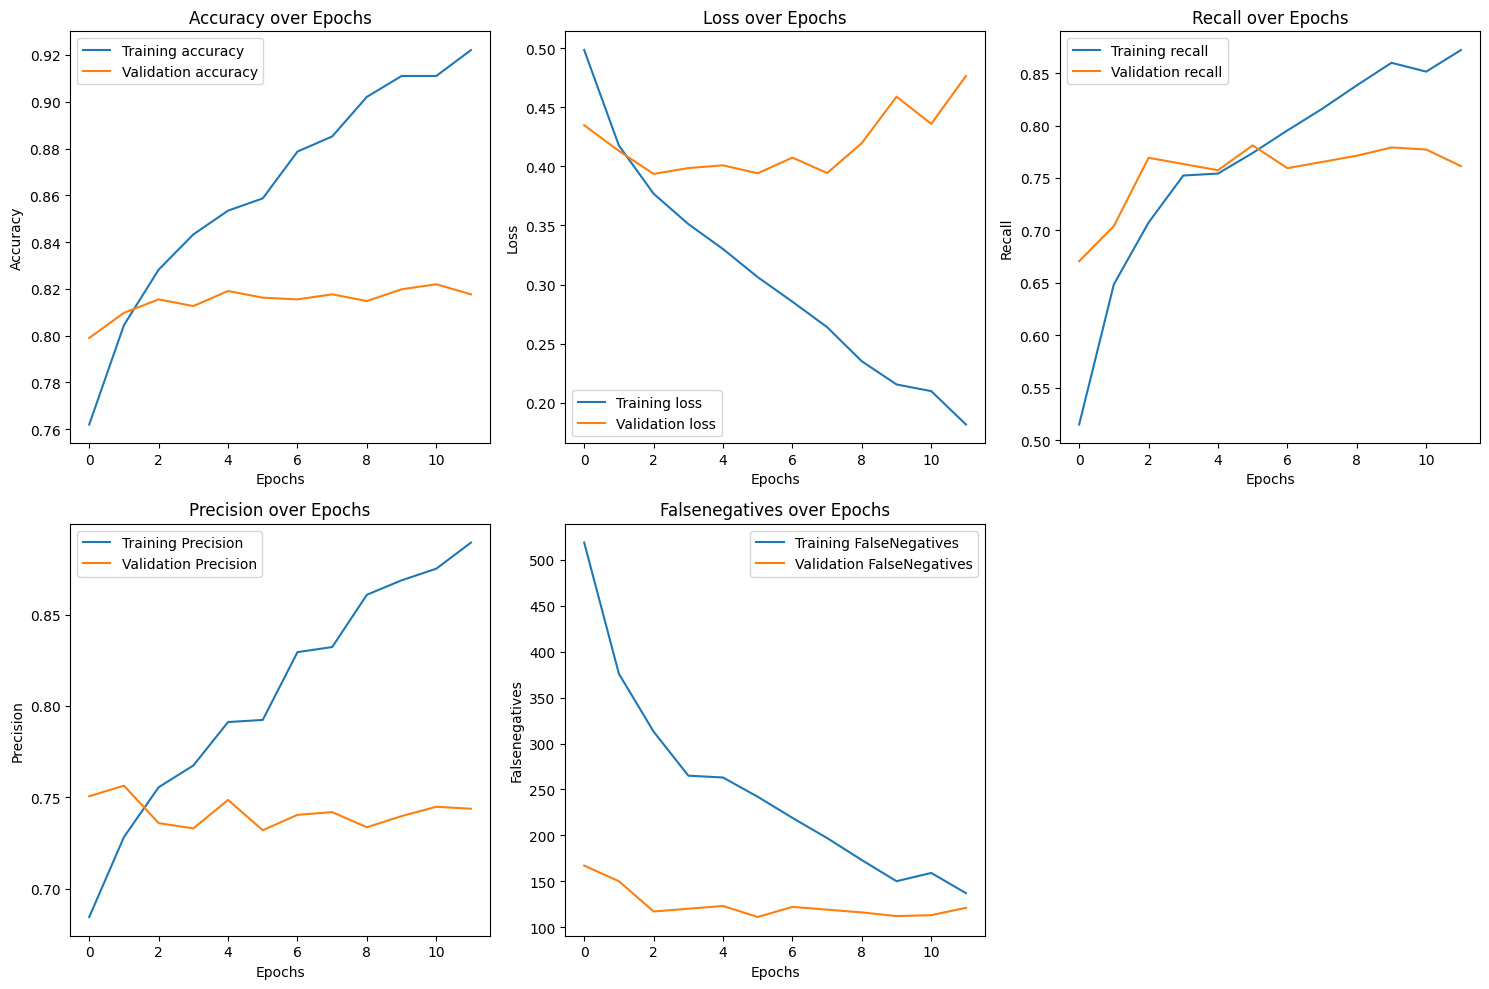

In [135]:
plot_all_metrics(history_D)

In [118]:
cnn_model = create_cnn_model(input_shape_text, input_shape_num)
history_E = cnn_model.fit([train_elmo_embed_np, X_train_num], y_train,
                   epochs = 12,
                   batch_size = 16,
                   validation_split = 0.2)

Epoch 1/12
232/232 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - FalseNegatives: 292.2747 - Precision: 0.6314 - accuracy: 0.7322 - loss: 0.5330 - recall: 0.4929 - val_FalseNegatives: 102.0000 - val_Precision: 0.7556 - val_accuracy: 0.8084 - val_loss: 0.4185 - val_recall: 0.6973
Epoch 2/12
232/232 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - FalseNegatives: 213.8498 - Precision: 0.7403 - accuracy: 0.8077 - loss: 0.4152 - recall: 0.6638 - val_FalseNegatives: 96.0000 - val_Precision: 0.7675 - val_accuracy: 0.8181 - val_loss: 0.4064 - val_recall: 0.7151
Epoch 3/12
232/232 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - FalseNegatives: 184.8240 - Precision: 0.7731 - accuracy: 0.8316 - loss: 0.3714 - recall: 0.7084 - val_FalseNegatives: 94.0000 - val_Precision: 0.7764 - val_accuracy: 0.8235 - val_loss: 0.4069 - val_recall: 0.7211
Epoch 4/12
232/232 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - FalseNegatives: 146.7639 - Precision: 0.7737 - accuracy: 0.8473 - loss: 0.3445 - recall: 0.7739 - val_FalseNegatives: 84.0000 - val_Precision: 0

In [139]:
cnn_model = create_cnn_model(input_shape_text, input_shape_num)
history_E = cnn_model.fit([train_elmo_embed_np, X_train_num], y_train,
                   epochs = 5,
                   batch_size = 32,
                   validation_split = 0.2)

Epoch 1/5
116/116 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - FalseNegatives: 322.1197 - Precision: 0.6140 - accuracy: 0.7205 - loss: 0.5487 - recall: 0.4465 - val_FalseNegatives: 89.0000 - val_Precision: 0.7294 - val_accuracy: 0.8052 - val_loss: 0.4212 - val_recall: 0.7359
Epoch 2/5
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - FalseNegatives: 212.3077 - Precision: 0.7479 - accuracy: 0.8113 - loss: 0.4208 - recall: 0.6636 - val_FalseNegatives: 90.0000 - val_Precision: 0.7462 - val_accuracy: 0.8127 - val_loss: 0.3994 - val_recall: 0.7329
Epoch 3/5
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - FalseNegatives: 184.8120 - Precision: 0.7536 - accuracy: 0.8235 - loss: 0.3878 - recall: 0.7085 - val_FalseNegatives: 79.0000 - val_Precision: 0.7457 - val_accuracy: 0.8202 - val_loss: 0.3886 - val_recall: 0.7656
Epoch 4/5
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - FalseNegatives: 167.1966 - Precision: 0.7786 - accuracy: 0.8428 - loss: 0.3557 - recall: 0.7454 - val_FalseNegatives: 82.0000 - val_Precision: 0.7658

In [126]:
cnn_model = create_cnn_model(input_shape_text, input_shape_num)
history_E2 = cnn_model.fit([train_elmo_embed_np, X_train_num], y_train,
                   epochs = 5,
                   batch_size = 16,
                   validation_split = 0.2)

Epoch 1/5
232/232 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - FalseNegatives: 296.2103 - Precision: 0.6276 - accuracy: 0.7298 - loss: 0.5356 - recall: 0.4801 - val_FalseNegatives: 108.0000 - val_Precision: 0.7816 - val_accuracy: 0.8149 - val_loss: 0.4171 - val_recall: 0.6795
Epoch 2/5
232/232 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - FalseNegatives: 206.9957 - Precision: 0.7222 - accuracy: 0.8025 - loss: 0.4099 - recall: 0.6728 - val_FalseNegatives: 92.0000 - val_Precision: 0.7562 - val_accuracy: 0.8159 - val_loss: 0.4014 - val_recall: 0.7270
Epoch 3/5
232/232 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - FalseNegatives: 174.6996 - Precision: 0.7712 - accuracy: 0.8344 - loss: 0.3695 - recall: 0.7247 - val_FalseNegatives: 98.0000 - val_Precision: 0.7914 - val_accuracy: 0.8267 - val_loss: 0.4129 - val_recall: 0.7092
Epoch 4/5
232/232 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - FalseNegatives: 159.9485 - Precision: 0.7787 - accuracy: 0.8449 - loss: 0.3469 - recall: 0.7542 - val_FalseNegatives: 87.0000 - val_Precision: 0.788

In [127]:
cnn_model = create_cnn_model(input_shape_text, input_shape_num)
history_E3 = cnn_model.fit([train_elmo_embed_np, X_train_num], y_train,
                   epochs = 4,
                   batch_size = 16,
                   validation_split = 0.2)

Epoch 1/4
232/232 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - FalseNegatives: 295.0730 - Precision: 0.6302 - accuracy: 0.7317 - loss: 0.5413 - recall: 0.4803 - val_FalseNegatives: 105.0000 - val_Precision: 0.7532 - val_accuracy: 0.8052 - val_loss: 0.4191 - val_recall: 0.6884
Epoch 2/4
232/232 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - FalseNegatives: 203.0386 - Precision: 0.7298 - accuracy: 0.8076 - loss: 0.4105 - recall: 0.6814 - val_FalseNegatives: 114.0000 - val_Precision: 0.7908 - val_accuracy: 0.8138 - val_loss: 0.4180 - val_recall: 0.6617
Epoch 3/4
232/232 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - FalseNegatives: 184.0086 - Precision: 0.7561 - accuracy: 0.8248 - loss: 0.3719 - recall: 0.7103 - val_FalseNegatives: 92.0000 - val_Precision: 0.7585 - val_accuracy: 0.8170 - val_loss: 0.3976 - val_recall: 0.7270
Epoch 4/4
232/232 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - FalseNegatives: 162.0730 - Precision: 0.7878 - accuracy: 0.8463 - loss: 0.3408 - recall: 0.7450 - val_FalseNegatives: 91.0000 - val_Precision: 0.78

In [128]:
cnn_model = create_cnn_model(input_shape_text, input_shape_num)
history_E4 = cnn_model.fit([train_elmo_embed_np, X_train_num], y_train,
                   epochs = 4,
                   batch_size = 32,
                   validation_split = 0.2)

Epoch 1/4
116/116 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - FalseNegatives: 325.2308 - Precision: 0.5878 - accuracy: 0.7090 - loss: 0.5492 - recall: 0.4308 - val_FalseNegatives: 86.0000 - val_Precision: 0.7382 - val_accuracy: 0.8116 - val_loss: 0.4179 - val_recall: 0.7448
Epoch 2/4
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - FalseNegatives: 191.7863 - Precision: 0.7348 - accuracy: 0.8152 - loss: 0.4127 - recall: 0.7063 - val_FalseNegatives: 95.0000 - val_Precision: 0.7683 - val_accuracy: 0.8192 - val_loss: 0.3995 - val_recall: 0.7181
Epoch 3/4
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - FalseNegatives: 174.6838 - Precision: 0.7565 - accuracy: 0.8301 - loss: 0.3713 - recall: 0.7318 - val_FalseNegatives: 86.0000 - val_Precision: 0.7723 - val_accuracy: 0.8278 - val_loss: 0.3890 - val_recall: 0.7448
Epoch 4/4
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - FalseNegatives: 170.4274 - Precision: 0.7688 - accuracy: 0.8379 - loss: 0.3488 - recall: 0.7417 - val_FalseNegatives: 75.0000 - val_Precision: 0.7594

In [129]:
cnn_model = create_cnn_model(input_shape_text, input_shape_num)
history_E5 = cnn_model.fit([train_elmo_embed_np, X_train_num], y_train,
                   epochs = 4,
                   batch_size = 64,
                   validation_split = 0.2)

Epoch 1/4
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - FalseNegatives: 359.5932 - Precision: 0.5917 - accuracy: 0.7019 - loss: 0.5660 - recall: 0.3966 - val_FalseNegatives: 97.0000 - val_Precision: 0.7668 - val_accuracy: 0.8170 - val_loss: 0.4213 - val_recall: 0.7122
Epoch 2/4
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - FalseNegatives: 210.3729 - Precision: 0.7429 - accuracy: 0.8119 - loss: 0.4254 - recall: 0.6769 - val_FalseNegatives: 95.0000 - val_Precision: 0.7781 - val_accuracy: 0.8235 - val_loss: 0.4050 - val_recall: 0.7181
Epoch 3/4
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - FalseNegatives: 172.7627 - Precision: 0.7581 - accuracy: 0.8318 - loss: 0.3809 - recall: 0.7368 - val_FalseNegatives: 96.0000 - val_Precision: 0.7928 - val_accuracy: 0.8288 - val_loss: 0.3955 - val_recall: 0.7151
Epoch 4/4
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - FalseNegatives: 168.5085 - Precision: 0.7699 - accuracy: 0.8374 - loss: 0.3569 - recall: 0.7396 - val_FalseNegatives: 89.0000 - val_Precision: 0.7823 - val_a

In [134]:
cnn_model = create_cnn_model(input_shape_text, input_shape_num)
history_E6 = cnn_model.fit([train_elmo_embed_np, X_train_num], y_train,
                   epochs = 4,
                   batch_size = 12,
                   validation_split = 0.2)

Epoch 1/4
310/310 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - FalseNegatives: 291.0868 - Precision: 0.6194 - accuracy: 0.7261 - loss: 0.5502 - recall: 0.5053 - val_FalseNegatives: 113.0000 - val_Precision: 0.7467 - val_accuracy: 0.7966 - val_loss: 0.4249 - val_recall: 0.6647
Epoch 2/4
310/310 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - FalseNegatives: 205.0225 - Precision: 0.7367 - accuracy: 0.8100 - loss: 0.4053 - recall: 0.6795 - val_FalseNegatives: 92.0000 - val_Precision: 0.7609 - val_accuracy: 0.8181 - val_loss: 0.4046 - val_recall: 0.7270
Epoch 3/4
310/310 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - FalseNegatives: 182.0096 - Precision: 0.7492 - accuracy: 0.8234 - loss: 0.3875 - recall: 0.7157 - val_FalseNegatives: 101.0000 - val_Precision: 0.7841 - val_accuracy: 0.8213 - val_loss: 0.3963 - val_recall: 0.7003
Epoch 4/4
310/310 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - FalseNegatives: 155.8939 - Precision: 0.7691 - accuracy: 0.8420 - loss: 0.3581 - recall: 0.7591 - val_FalseNegatives: 81.0000 - val_Precision: 0.75

In [136]:
cnn_model = create_cnn_model(input_shape_text, input_shape_num)
history_E7 = cnn_model.fit([train_elmo_embed_np, X_train_num], y_train,
                   epochs = 7,
                   batch_size = 12,
                   validation_split = 0.2)

Epoch 1/7
310/310 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - FalseNegatives: 288.2990 - Precision: 0.6240 - accuracy: 0.7297 - loss: 0.5277 - recall: 0.4997 - val_FalseNegatives: 121.0000 - val_Precision: 0.7770 - val_accuracy: 0.8030 - val_loss: 0.4246 - val_recall: 0.6409
Epoch 2/7
310/310 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - FalseNegatives: 193.9775 - Precision: 0.7355 - accuracy: 0.8126 - loss: 0.4127 - recall: 0.6937 - val_FalseNegatives: 114.0000 - val_Precision: 0.7743 - val_accuracy: 0.8073 - val_loss: 0.4152 - val_recall: 0.6617
Epoch 3/7
310/310 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - FalseNegatives: 177.9228 - Precision: 0.7554 - accuracy: 0.8281 - loss: 0.3723 - recall: 0.7251 - val_FalseNegatives: 84.0000 - val_Precision: 0.7507 - val_accuracy: 0.8192 - val_loss: 0.4056 - val_recall: 0.7507
Epoch 4/7
310/310 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - FalseNegatives: 167.1865 - Precision: 0.7838 - accuracy: 0.8446 - loss: 0.3396 - recall: 0.7437 - val_FalseNegatives: 90.0000 - val_Precision: 0.78

In [137]:
cnn_model = create_cnn_model(input_shape_text, input_shape_num)
history_E8 = cnn_model.fit([train_elmo_embed_np, X_train_num], y_train,
                   epochs = 7,
                   batch_size = 16,
                   validation_split = 0.2)

Epoch 1/7
232/232 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - FalseNegatives: 290.1588 - Precision: 0.6128 - accuracy: 0.7251 - loss: 0.5376 - recall: 0.4880 - val_FalseNegatives: 107.0000 - val_Precision: 0.7541 - val_accuracy: 0.8041 - val_loss: 0.4185 - val_recall: 0.6825
Epoch 2/7
232/232 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - FalseNegatives: 201.8498 - Precision: 0.7384 - accuracy: 0.8113 - loss: 0.4006 - recall: 0.6829 - val_FalseNegatives: 105.0000 - val_Precision: 0.7708 - val_accuracy: 0.8127 - val_loss: 0.4077 - val_recall: 0.6884
Epoch 3/7
232/232 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - FalseNegatives: 182.1631 - Precision: 0.7651 - accuracy: 0.8286 - loss: 0.3730 - recall: 0.7099 - val_FalseNegatives: 93.0000 - val_Precision: 0.7796 - val_accuracy: 0.8256 - val_loss: 0.3956 - val_recall: 0.7240
Epoch 4/7
232/232 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - FalseNegatives: 155.8498 - Precision: 0.8058 - accuracy: 0.8595 - loss: 0.3472 - recall: 0.7676 - val_FalseNegatives: 95.0000 - val_Precision: 0.78

In [120]:
cnn_model = create_cnn_model(input_shape_text, input_shape_num)
history_F = cnn_model.fit([train_elmo_embed_np, X_train_num], y_train,
                   epochs = 5,
                   batch_size = 32,
                   validation_split = 0.3)

Epoch 1/5
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - FalseNegatives: 308.3981 - Precision: 0.5576 - accuracy: 0.7105 - loss: 0.5615 - recall: 0.3537 - val_FalseNegatives: 141.0000 - val_Precision: 0.7394 - val_accuracy: 0.8062 - val_loss: 0.4340 - val_recall: 0.7219
Epoch 2/5
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - FalseNegatives: 180.2427 - Precision: 0.7053 - accuracy: 0.8037 - loss: 0.4253 - recall: 0.6656 - val_FalseNegatives: 135.0000 - val_Precision: 0.7515 - val_accuracy: 0.8148 - val_loss: 0.4117 - val_recall: 0.7337
Epoch 3/5
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - FalseNegatives: 158.5437 - Precision: 0.7299 - accuracy: 0.8219 - loss: 0.3916 - recall: 0.7084 - val_FalseNegatives: 122.0000 - val_Precision: 0.7432 - val_accuracy: 0.8169 - val_loss: 0.4032 - val_recall: 0.7594
Epoch 4/5
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - FalseNegatives: 150.3301 - Precision: 0.7465 - accuracy: 0.8314 - loss: 0.3612 - recall: 0.7202 - val_FalseNegatives: 98.0000 - val_Precision: 0.7

In [138]:
cnn_model = create_cnn_model(input_shape_text, input_shape_num)
history_E8 = cnn_model.fit([train_elmo_embed_np, X_train_num], y_train,
                   epochs = 7,
                   batch_size = 32,
                   validation_split = 0.2)

Epoch 1/7
116/116 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - FalseNegatives: 333.1966 - Precision: 0.5683 - accuracy: 0.6949 - loss: 0.5638 - recall: 0.4217 - val_FalseNegatives: 85.0000 - val_Precision: 0.7478 - val_accuracy: 0.8170 - val_loss: 0.4134 - val_recall: 0.7478
Epoch 2/7
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - FalseNegatives: 198.1795 - Precision: 0.7350 - accuracy: 0.8134 - loss: 0.4199 - recall: 0.6974 - val_FalseNegatives: 88.0000 - val_Precision: 0.7638 - val_accuracy: 0.8224 - val_loss: 0.3988 - val_recall: 0.7389
Epoch 3/7
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - FalseNegatives: 179.6752 - Precision: 0.7702 - accuracy: 0.8349 - loss: 0.3756 - recall: 0.7275 - val_FalseNegatives: 80.0000 - val_Precision: 0.7626 - val_accuracy: 0.8278 - val_loss: 0.3898 - val_recall: 0.7626
Epoch 4/7
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - FalseNegatives: 155.4701 - Precision: 0.7878 - accuracy: 0.8530 - loss: 0.3487 - recall: 0.7712 - val_FalseNegatives: 73.0000 - val_Precision: 0.7437

In [123]:
cnn_model = create_cnn_model(input_shape_text, input_shape_num)
history_G = cnn_model.fit([train_elmo_embed_np, X_train_num], y_train,
                   epochs = 5,
                   batch_size = 12,
                   validation_split = 0.3)

Epoch 1/5
271/271 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - FalseNegatives: 272.1507 - Precision: 0.5952 - accuracy: 0.7346 - loss: 0.5358 - recall: 0.4090 - val_FalseNegatives: 130.0000 - val_Precision: 0.7292 - val_accuracy: 0.8062 - val_loss: 0.4305 - val_recall: 0.7436
Epoch 2/5
271/271 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - FalseNegatives: 168.8125 - Precision: 0.7049 - accuracy: 0.8063 - loss: 0.4146 - recall: 0.6819 - val_FalseNegatives: 116.0000 - val_Precision: 0.7241 - val_accuracy: 0.8098 - val_loss: 0.4141 - val_recall: 0.7712
Epoch 3/5
271/271 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - FalseNegatives: 153.5221 - Precision: 0.7237 - accuracy: 0.8190 - loss: 0.3910 - recall: 0.7032 - val_FalseNegatives: 123.0000 - val_Precision: 0.7589 - val_accuracy: 0.8241 - val_loss: 0.4013 - val_recall: 0.7574
Epoch 4/5
271/271 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - FalseNegatives: 144.6029 - Precision: 0.7496 - accuracy: 0.8357 - loss: 0.3621 - recall: 0.7320 - val_FalseNegatives: 142.0000 - val_Precision: 0.

In [124]:
cnn_model = create_cnn_model(input_shape_text, input_shape_num)
history_H = cnn_model.fit([train_elmo_embed_np, X_train_num], y_train,
                   epochs = 5,
                   batch_size = 16,
                   validation_split = 0.25)

Epoch 1/5
218/218 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - FalseNegatives: 273.3196 - Precision: 0.6076 - accuracy: 0.7232 - loss: 0.5383 - recall: 0.4881 - val_FalseNegatives: 108.0000 - val_Precision: 0.7192 - val_accuracy: 0.8010 - val_loss: 0.4289 - val_recall: 0.7447
Epoch 2/5
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - FalseNegatives: 183.3288 - Precision: 0.7138 - accuracy: 0.8011 - loss: 0.4137 - recall: 0.6779 - val_FalseNegatives: 90.0000 - val_Precision: 0.7303 - val_accuracy: 0.8165 - val_loss: 0.4144 - val_recall: 0.7872
Epoch 3/5
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - FalseNegatives: 155.5023 - Precision: 0.7619 - accuracy: 0.8346 - loss: 0.3764 - recall: 0.7357 - val_FalseNegatives: 86.0000 - val_Precision: 0.7021 - val_accuracy: 0.8028 - val_loss: 0.4175 - val_recall: 0.7967
Epoch 4/5
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - FalseNegatives: 145.0548 - Precision: 0.7677 - accuracy: 0.8411 - loss: 0.3549 - recall: 0.7569 - val_FalseNegatives: 89.0000 - val_Precision: 0.734

## Testing

In [242]:
# Evaluate the model
evaluation_results = cnn_model.evaluate([test_elmo_embed_np, X_test_num], y_test)
# Print all evaluation metrics
print("Evaluation Results:", evaluation_results)

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 558us/step - FalseNegatives: 64.3421 - Precision: 0.7844 - accuracy: 0.8373 - loss: 0.3845 - recall: 0.6947
Evaluation Results: [0.39261260628700256, 0.832041323184967, 0.703797459602356, 0.7808988690376282, 117.0]


In [243]:
# Assigning metrics to variables for better readability
loss = evaluation_results[0]
accuracy = evaluation_results[1]
recall = evaluation_results[2]
precision = evaluation_results[3]
false_negatives = evaluation_results[4]

# Printing the metrics
print(f'Test Loss: {loss}')
print(f'Test Accuracy: {accuracy}')
print(f'Test Recall: {recall}')
print(f'Test Precision: {precision}')
print(f'Test False Negatives: {false_negatives}')

Test Loss: 0.39261260628700256
Test Accuracy: 0.832041323184967
Test Recall: 0.703797459602356
Test Precision: 0.7808988690376282
Test False Negatives: 117.0


In [244]:
#make prediction 
preds = np.round(cnn_model.predict([test_elmo_embed_np, X_test_num]))
print('Number of predictions made by the model: {}'.format(len(preds)))

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Number of predictions made by the model: 1161


In [245]:
# calculate evaluation metrics to compare the testing values vs actual values
accuracy = accuracy_score(y_test, preds)
print('Accuracy: \t{:.4f}'.format(accuracy))

recall = recall_score(y_test, preds)
print('Recall: \t{:.4f}'.format(recall))

precision = precision_score(y_test, preds)
print('Precision: \t{:.4f}'.format(precision))

Accuracy: 	0.8320
Recall: 	0.7038
Precision: 	0.7809


In [246]:
#save predicted data to a variable 
y_pred = np.round(preds)

#print assessment metrics report
print('Assessment Metrics Report'.center(65) + ('\n') + ('-'*65))
#the sklearn classification report module takes in the actual values and 
# the predicted values as well as to what decimal places the values must be displayed and
# outputs a classification report based on this
print(classification_report(y_test, y_pred, digits=4) + ('\n') + ('-') * 15)

                    Assessment Metrics Report                    
-----------------------------------------------------------------
              precision    recall  f1-score   support

           0     0.8547    0.8982    0.8759       766
           1     0.7809    0.7038    0.7403       395

    accuracy                         0.8320      1161
   macro avg     0.8178    0.8010    0.8081      1161
weighted avg     0.8296    0.8320    0.8298      1161

---------------
